## Make the data plots needed for the high-z clustering paper

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from astropy.table import Table
from astropy.io import fits as pf
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy import integrate
from scipy import stats
sys.path.insert(0, '/home/john/densityplot/densityplot')
from densityplot.hex_scatter import hex_contour as hex_contour
from sklearn.neighbors import KernelDensity as kde
import camb
from camb import model


In [2]:
'''
#Plotting Parameters (Replace with Group code call!)
params = {'legend.fontsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'xtick.major.width':2, 'xtick.minor.width':2, 'ytick.major.width':2, 'ytick.minor.width':2, 'xtick.major.size':8, 'xtick.minor.size':6, 'ytick.major.size':8, 'ytick.minor.size':6}
plt.rcParams.update(params)
plt.rc("axes", linewidth=3.0)

'''
import matplotlib as mpl
def figsze(hscale, 
            vscale=0.618034,
            fig_width_pt = 504.0):
    """Get the fig_width_pt by inserting the textwidth into LaTeX document.
    hscale is fraction of text width you want.
    vscale is fraction of hscale (defaults to golden ratio)  
    """
   
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt*hscale   # width in inches
    fig_height = fig_width*vscale                   # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "axes.linewidth":1.5,               # width of box, 2 is too wide, 1 is too narrow
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    #"text.usetex": True, 
    #"text.latex.unicode": True,          # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 16,               # LaTeX default is 10pt font, font size of axis text label
    "axes.labelpad" : 6,                # Distance between label and axis
    "axes.formatter.limits":[-99,99],   # use sci notation if log10 of axis range is smaller than first or larger than second.
                                        # GTR: Actually *don't* -- should change the axis label instead.  E.g., "Flux Density (10^-17 ergs/s/cm^2)" 
                                        # This is a hack b/c there doesn't seem to be an rcParams version of
                                        # axes.ticklabel_format(style='plain')
    #"axes.formatter.style":"plain",    # Turn off multiplicative offsets (sci notation) to the axes [GTR: Doesn't work]
    "axes.formatter.useoffset":False,   # Turn off additive offsets to the axes
    "font.size": 16,
    "legend.fontsize": 12,              # Make the legend/label fonts a little smaller
    "xtick.labelsize": 16,              # Font size of numbers 
    "ytick.labelsize": 16,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    'xtick.major.width':1, 
    'xtick.minor.width':1, 
    'ytick.major.width':1, 
    'ytick.minor.width':1, 
    'xtick.major.size':10,             # size of tickmarks in points
    'xtick.minor.size':5, 
    'ytick.major.size':10, 
    'ytick.minor.size':5,
    'xtick.major.pad':8,               # distance between box and numbers
    'ytick.major.pad':8,
    "figure.figsize": figsze(1,1),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts because your computer can handle it
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }

mpl.rcParams.update(pgf_with_latex)


(1378, 1)
[ 2.9005184   2.90212296  2.90372752 ...,  5.10679101  5.10839557
  5.11000013]
done
(0.9683159136306184, 0.00021142137223073565)
3.1930000782
3.31089834534
5.23000001907
0.125894832963


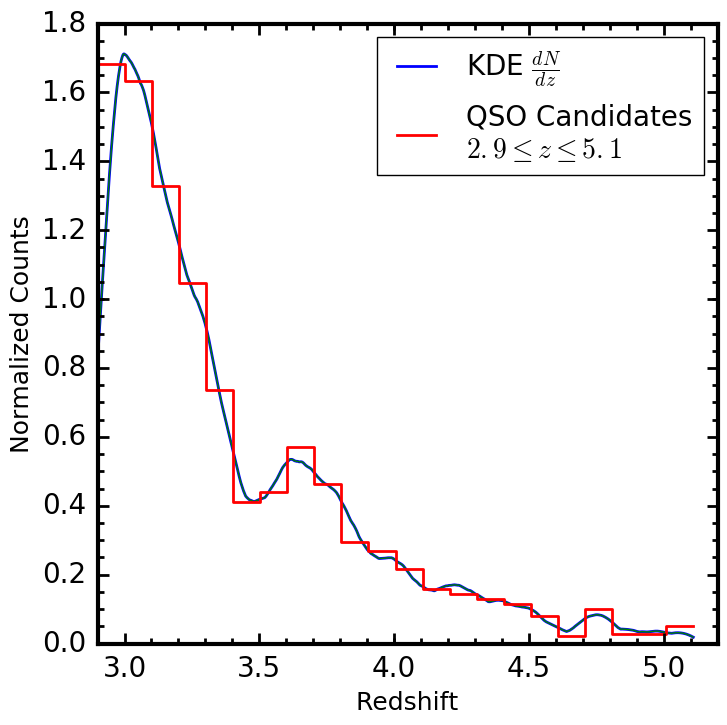

In [22]:
#Import SpIES / SHELA data
data = '/Users/johntimlin/Complete_Clustering_Analysis/Clustering/Data_sets/HZLZ_combined_all_hzclassifiers_wphotoz_zspecflg.fits'
obs = pf.open(data)[1].data
Z = obs.zbest
#gdx = ((Z >= 2.9)&(Z <= 5.2) & (obs.dec>=-1.2) & (obs.dec<=1.2))
gdx = (obs.dec>=-1.2) & (obs.dec<=1.2) & (Z>=2.9)&(Z <= 5.2) & ((obs.ra>=344.4)|(obs.ra<60))
#gdx = ((Z >= 2.9)&(Z <= 3.4) & (obs.Good_obj == 0)) & (obs.dec>=-1.2) & (obs.dec<=1.2)
#gdx = ((Z >= 3.4)&(Z <= 5.2) & (obs.Good_obj == 0)) & (obs.dec>=-1.2) & (obs.dec<=1.2)

#gdx = Z>0
#Set up a KDE for dNdz
tmpz = Z[gdx][:, np.newaxis] #change the array from row shape (1) to column shape (1,)
print np.shape(tmpz)
sample_range = np.linspace(min(tmpz[:, 0]), max(tmpz[:, 0]), len(tmpz[:, 0]))[:, np.newaxis]

est = kde(bandwidth=0.1,kernel='epanechnikov') #Set up the Kernel

histkde = est.fit(tmpz).score_samples(sample_range) #fit the kernel to the data and find the density of the grid
#Interpolate (you get the same function back) to plug in any z in the range (as opposed to set z values)
dNdz = interpolate.interp1d(sample_range.flatten(),np.exp(histkde))
print sample_range.flatten()
print 'done'
ZE = np.linspace(min(Z),max(Z),100)
xo=integrate.quad(dNdz,min(sample_range),max(sample_range)) #quad(f(x),xlower,xupper, args)
print xo
print np.median(Z)
print np.mean(Z)
print np.max(Z)
print np.min(Z)

#Plotting Parameters (Replace with Group code call!)
#params = {'legend.fontsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'xtick.major.width':2, 'xtick.minor.width':2, 'ytick.major.width':2, 'ytick.minor.width':2, 'xtick.major.size':8, 'xtick.minor.size':6, 'ytick.major.size':8, 'ytick.minor.size':6}
#plt.rcParams.update(params)
#plt.rc("axes", linewidth=3.0)


num,bins = np.histogram(Z[gdx],bins='fd',normed=True)

#Compute the redshift percentiles for the Friedmann-Diaconis rule for bin width
#q75, q25 = np.percentile(obs.ZSPEC[gdx], [75 ,25])
#iqr = q75 - q25
#FD = 2*iqr /(len(obs.ZSPEC[gdx]))**(1/3.0)
#Set up the bin range from using the Friedmann Diaconis bin width
#bins = np.arange(min(obs.ZSPEC[gdx]),max(obs.ZSPEC[gdx]),FD)


#Plot the KDE dndz
plt.figure(1,figsize = [8,8])
plt.plot(sample_range[:,0],np.exp(histkde),linewidth = 2, label = r'KDE $\frac{dN}{dz}$')
plt.plot(sample_range[:,0],dNdz(sample_range[:,0]))
plt.plot(bins[:],np.append(num,num[-1]),linestyle = 'steps-post',linewidth = 2, label='QSO Candidates' + '\n'+ r'$2.9 \leq z \leq 5.1$')
#ZE = np.linspace(min(Z),max(Z),100)
#xo=integrate.quad(dNdz,min(sample_range),max(sample_range)) #quad(f(x),xlower,xupper, args)
#print xo
plt.xlim(2.9,5.2)
plt.xlabel('Redshift',fontsize = 18)
plt.ylabel('Normalized Counts',fontsize = 18)
plt.legend(fontsize = 20)
#plt.savefig('./Paper_plots/dndz.pdf')
plt.show() 

15891
8416
7475
694 437
0.933638443936
0.932276657061


/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater
/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less_equal


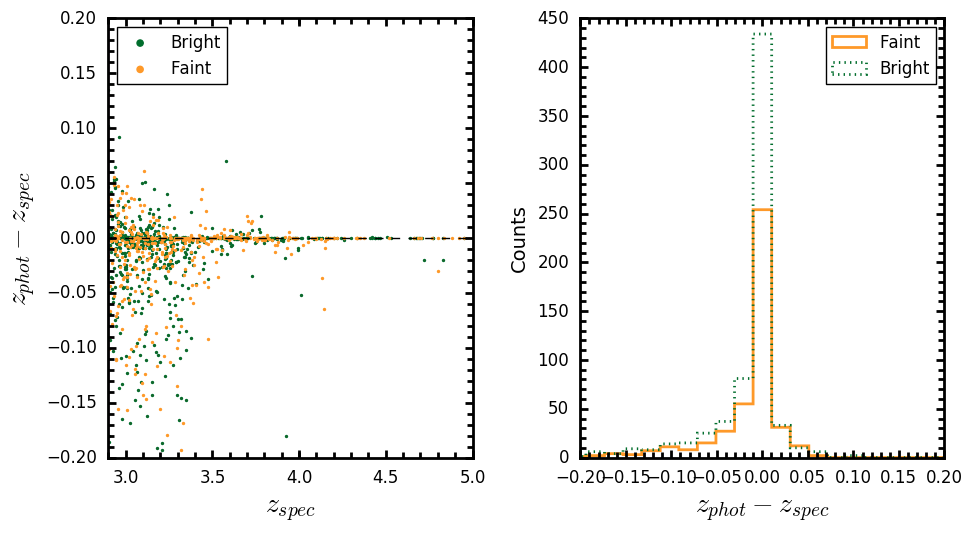

In [14]:
dat = '/Users/johntimlin/Complete_Clustering_Analysis/Clustering/Data_sets/QSOs_S82_wzspec_wcolors_wphotoz.fits'
data = pf.open(dat)[1].data

zspec = data['zspec']
zphotnw = data['zphotNW']
zphotrf = data['zphotRF']
imag = 22.5-2.5*np.log10(data['iflux'])

print len(imag)
print len(imag[imag<=20.2])
print len(imag[imag>20.2])


#Split the above histogram in imag
#Less than i = 20.2
fulldiff = zphotnw[(zspec>=2.9) & (imag<=20.2)]-zspec[(zspec>=2.9) & (imag<=20.2)]
fulldiff2 = fulldiff[(fulldiff>0) | (fulldiff <=0)]
#Greater than i=20.2
hzdiffs = zphotnw[(zspec>=2.9) & (imag>=20.2)]-zspec[(zspec>=2.9) & (imag>=20.2)]
hzdiffs2 = hzdiffs[(hzdiffs>0) | (hzdiffs <=0)]

print len(hzdiffs2),len(fulldiff2)

print len(fulldiff2[(fulldiff2>-0.1) & (fulldiff2<0.1)])/float(len(fulldiff2))
print len(hzdiffs2[(hzdiffs2>-0.1) & (hzdiffs2<0.1)])/float(len(hzdiffs2))

bins = np.linspace(-0.5,0.5,50)
#Plotting Parameters (Replace with Group code call!)
params = {'legend.fontsize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'xtick.major.width':2, 'xtick.minor.width':2, 'ytick.major.width':2, 'ytick.minor.width':2, 'xtick.major.size':6, 'xtick.minor.size':4, 'ytick.major.size':6, 'ytick.minor.size':4}
plt.rcParams.update(params)
plt.rc("axes", linewidth=2.0)

#Plot for paper
fig = plt.figure(1,figsize = (10,10))
gs = gridspec.GridSpec(1,2, height_ratios=[1, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.scatter(zspec[imag>=20.2],zphotnw[imag>=20.2]-zspec[imag>=20.2], s = 2, edgecolor = '#006d2c',facecolor = 'r', alpha = 1,label = None)
ax0.scatter(100,100, s = 20, edgecolor = '#006d2c',facecolor = '#006d2c', label = 'Bright')

ax0.scatter(zspec[imag<=20.2],zphotnw[imag<=20.2]-zspec[imag<=20.2], s = 2, edgecolor = '#fe9929',facecolor = '#fe9929', alpha = 1,label = None)
ax0.scatter(100,100, s = 20, edgecolor = '#fe9929',facecolor = '#fe9929', label = 'Faint')



ax0.axhline(0,color = 'k', linestyle = '--')
ax0.axvline(2.9,color = 'm')
#ax0.axhline(2.9,color = 'm')
ax0.set_ylim(-0.2,0.2)
ax0.set_xlim(2.9,5)
ax0.set_ylabel(r'$z_{phot} - z_{spec}$',fontsize = 20)
ax0.set_xlabel(r'$z_{spec}$',fontsize = 20)
ax0.legend(scatterpoints = 1, loc = 2)

ax1.hist(fulldiff2,bins, histtype = 'step',normed = False,color = '#fe9929',linewidth = 2,label = 'Faint')
ax1.hist(hzdiffs2, bins , histtype = 'step',normed = False,color = '#006d2c',linewidth = 2,linestyle = ':',label = 'Bright')
ax1.set_xlabel(r'$z_{phot} - z_{spec}$',fontsize = 20)
ax1.set_ylabel('Counts',fontsize = 14)
ax1.set_xlim(-0.2,0.2)
fig.tight_layout()
plt.legend()
#plt.savefig('./Revised_Plots/f3.pdf',bbox_inches='tight')

plt.show()


In [4]:
### DEFINE THE TRAINING SET
#JT PATH ON TRITON to training set after classification
#data = Table.read('/Users/johntimlin/Catalogs/QSO_candidates/Training_set/GTR-ADM-QSO-Trainingset-with-McGreer-VVDS-DR12Q_splitlabel_VCVcut_best.fits')
data = Table.read('/Users/johntimlin/Catalogs/QSO_Candidates/Training_set/GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_starclean_with_shenlabel.fits')


#Fill all cells in arrays
data = data.filled()

# Remove stars from training data 
qmask = (data['zspec']>0)
ext = (data['morph']!=6)
pt = (data['morph']==6)

qdata = data[qmask]
edata = data[ext]
pdata = data[pt]

### DEFINE THE TEST SET
# TEST DATA USING 2.9<z<5.4 zrange ON HOME
testdata = Table.read('/Users/johntimlin/Complete_Clustering_Analysis/Clustering/Data_sets/HZLZ_combined_all_hzclassifiers_wphotoz_zspecflg.fits')
#testdata = Table.read('/home/john/Clustering_Paper_Code_Stable/Angular_Clustering_Final/Data_Sets/QSO_Candidates_allcuts_with_errors_visualinsp.fits')

testdata=testdata.filled()
#Limit to objects that have been classified as quasars
#sqsocandmask = ((testdata['dec']>=-1.2) & (testdata['dec']<=1.2)) & (testdata['zbest']>=2.9)
qsocandmask = (testdata['dec']>=-1.2) & (testdata['dec']<=1.2) & (testdata['zbest']>=2.9) & ((testdata['ra']>=344.4)|(testdata['ra']<60))
testdatacand = testdata[qsocandmask]
print len(testdata),len(testdatacand)

1984 1378


In [5]:
#Find the mean of the distribution
#The purpose of this function is to compute the mean of the color-z distribution using the spectrocopic redshifts of
#known quasars
def Detect_mode(color, z, zbins = np.arange(0,5.5,0.1),sigval=1.0):
    
    modecol = []
    sigpl = []
    sigmin = []
    zavg = []
    for i in range(len(zbins)-1):
        #separate into the redshift bins
        zlow = zbins[i]
        zhigh = zbins[i+1]
        #Cut the color data according to bin
        flatcol = color[((z>=zlow)&(z<=zhigh))]
        tempcol = color[((z>=zlow)&(z<=zhigh))][:, np.newaxis] #change the array from row shape (1) to column shape (1,)
        #After the KDE is trained on the data colors, input an evenly spaced grid into the score_sample to get density
        sample_range = np.linspace(min(tempcol[:, 0]), max(tempcol[:, 0]), len(tempcol[:, 0]))[:, np.newaxis]
        #Run the KDE
        est = kde(bandwidth=0.1,kernel='epanechnikov') #Set up the Kernel
        value = est.fit(tempcol).score_samples(sample_range) #fit the kernel to the data and find the density of the grid
        med = sample_range[value == max(value)] #Find where the color with the maximum density       
        modecol.append(med[0][0]) #append the color to a list for interpolation
        
        ## Find the standard deviation of the data
        sigma_plus = np.sqrt(np.sum((flatcol[flatcol - med[0][0] >0.0] - med[0][0])**2) / float(len(flatcol[flatcol - med[0][0] >0.0]))) 
        sigma_minus = np.sqrt(np.sum((flatcol[flatcol - med[0][0] <0.0] - med[0][0])**2) / float(len(flatcol[flatcol - med[0][0] <0.0])))
        
        sigpl.append(sigma_plus)
        sigmin.append(sigma_minus)
        
        zavg.append((zlow+zhigh)/2.0)
        #zavg.append(zlow)
        '''
        #Plot the KDE for each redshift bin
        plt.plot(sample_range[:,0],np.exp(value))
        plt.show()       
        '''
    #Interpolate the color redshift relation given the average redshift and the densest colors at each redshift
    #Also interpolates the 1 sigma line above and below the mean
    
   
    col = interpolate.interp1d(zavg,np.asarray(modecol))
    sp = interpolate.interp1d(zavg,np.asarray(modecol)+sigval*np.asarray(sigpl))
    sm = interpolate.interp1d(zavg,np.asarray(modecol)-sigval*np.asarray(sigmin))

    
    return col,sp,sm

In [6]:
#Find the mode of the training data
ugmode = Detect_mode(qdata['ug'],qdata['zspec'])
grmode = Detect_mode(qdata['gr'],qdata['zspec'])
rimode = Detect_mode(qdata['ri'],qdata['zspec'])
izmode = Detect_mode(qdata['iz'],qdata['zspec'])
zc1mode = Detect_mode(qdata['zs1'],qdata['zspec'])
c1c2mode = Detect_mode(qdata['s1s2'],qdata['zspec'])


/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in double_scalars
/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in double_scalars


In [7]:
#look at the modes in the data space of interest
modeug = ugmode[0](np.linspace(0.1,5.3,100))
modegr = grmode[0](np.linspace(0.1,5.3,100))
moderi = rimode[0](np.linspace(0.1,5.3,100))
modeiz = izmode[0](np.linspace(0.1,5.3,100))
modezc1 = zc1mode[0](np.linspace(0.1,5.3,100))
modec1c2 = c1c2mode[0](np.linspace(0.1,5.3,100))


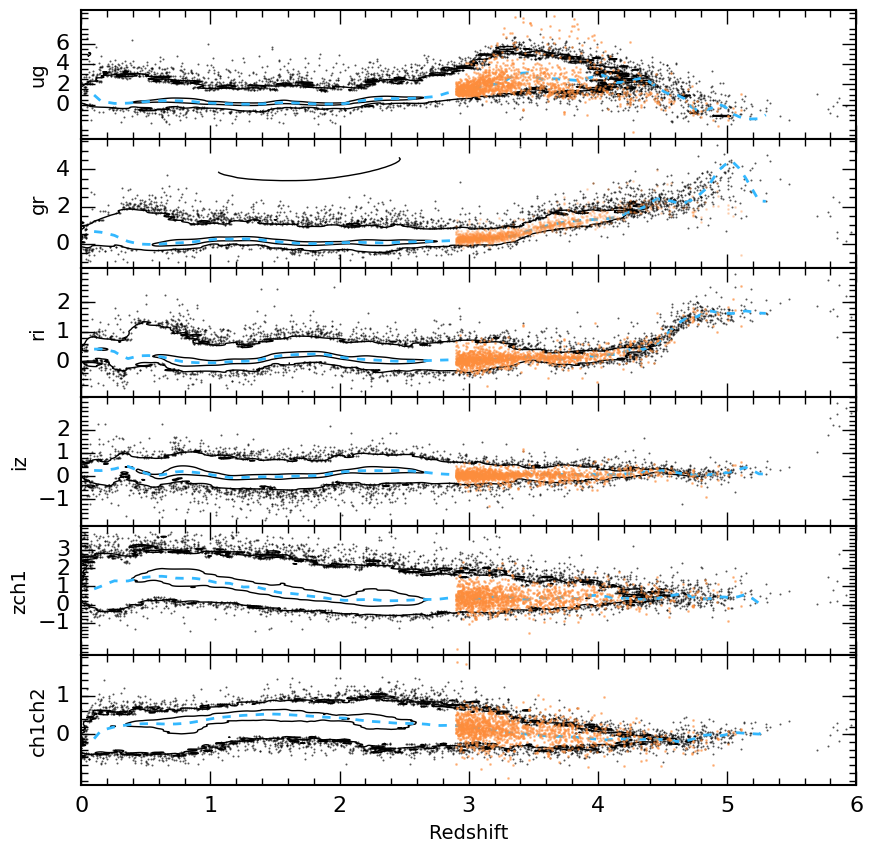

In [8]:
import matplotlib.pyplot as plt

#Plot for paper
fig = plt.figure(2,figsize = (10,10))
gs = gridspec.GridSpec(6, 1)#, width_ratios=[1,1])#,1,1,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharex = ax0)
ax2 = plt.subplot(gs[2],sharex = ax1)
ax3 = plt.subplot(gs[3],sharex = ax2)
ax4 = plt.subplot(gs[4],sharex = ax3)
ax5 = plt.subplot(gs[5],sharex = ax4)

plt.axes(ax0)
hex_contour(qdata['zspec'],qdata['ug'], levels=[0.5,0.99], std=True, min_cnt=7, smoothing=4, hkwargs={'gridsize':75}, skwargs={'color':'k','alpha':0.5,'marker':'.'}, ckwargs={'colors':'k','alpha':1,'linewidths':1})
plt.plot(np.linspace(0.1,5.3,100),modeug, linewidth = 2,linestyle = '--', color = '#33B8FF')
plt.scatter(testdatacand['zbest'],testdatacand['ug'],s = 1, color = '#fd8d3c',alpha = 0.5, zorder = 100)
ax0.set_xlim(0,6)
ax0.yaxis.set_ticks([0,2,4,6])
ax0.set_ylabel('ug',fontsize = 14)

plt.axes(ax1)
hex_contour(qdata['zspec'],qdata['gr'], levels=[0.5,0.99], std=True, min_cnt=7, smoothing=4, hkwargs={'gridsize':75}, skwargs={'color':'k','alpha':0.5,'marker':'.'}, ckwargs={'colors':'k','alpha':1,'linewidths':1})
plt.plot(np.linspace(0.1,5.3,100),modegr, linewidth = 2,linestyle = '--', color = '#33B8FF')
plt.scatter(testdatacand['zbest'],testdatacand['gr'],s = 1, color = '#fd8d3c',alpha = 0.255, zorder = 100)
#ax1.set_xlim(0,6)
ax1.yaxis.set_ticks([0,2,4])
ax1.set_ylabel('gr',fontsize = 14)

plt.axes(ax2)
hex_contour(qdata['zspec'],qdata['ri'], levels=[0.5,0.99], std=True, min_cnt=7, smoothing=4, hkwargs={'gridsize':75}, skwargs={'color':'k','alpha':0.5,'marker':'.'}, ckwargs={'colors':'k','alpha':1,'linewidths':1})
plt.plot(np.linspace(0.1,5.3,100),moderi, linewidth = 2,linestyle = '--', color = '#33B8FF')
plt.scatter(testdatacand['zbest'],testdatacand['ri'],s = 1, color = '#fd8d3c',alpha = 0.5, zorder = 100)
#ax2.set_xlim(0,6)
ax2.yaxis.set_ticks([0,1,2])
ax2.set_ylabel('ri',fontsize = 14)

plt.axes(ax3)
hex_contour(qdata['zspec'],qdata['iz'], levels=[0.5,0.99], std=True, min_cnt=7, smoothing=4, hkwargs={'gridsize':75}, skwargs={'color':'k','alpha':0.5,'marker':'.'}, ckwargs={'colors':'k','alpha':1,'linewidths':1})
plt.plot(np.linspace(0.1,5.3,100),modeiz, linewidth = 2,linestyle = '--', color = '#33B8FF')
plt.scatter(testdatacand['zbest'],testdatacand['iz'],s = 1, color = '#fd8d3c',alpha = 0.5, zorder = 100)
#ax3.set_xlim(0,6)
ax3.yaxis.set_ticks([-1,0,1,2])
ax3.set_ylabel('iz',fontsize = 14)

plt.axes(ax4)
hex_contour(qdata['zspec'],qdata['zs1'], levels=[0.5,0.99], std=True, min_cnt=7, smoothing=4, hkwargs={'gridsize':75}, skwargs={'color':'k','alpha':0.5,'marker':'.'}, ckwargs={'colors':'k','alpha':1,'linewidths':1})
plt.plot(np.linspace(0.1,5.3,100),modezc1, linewidth = 2,linestyle = '--', color = '#33B8FF')
plt.scatter(testdatacand['zbest'],testdatacand['zs1'],s = 1, color = '#fd8d3c',alpha = 0.5, zorder = 100)
#ax4.set_xlim(0,6)
ax4.yaxis.set_ticks([-1,0,1,2,3])
ax4.set_ylabel('zch1',fontsize = 14)

plt.axes(ax5)
hex_contour(qdata['zspec'],qdata['s1s2'], levels=[0.5,0.99], std=True, min_cnt=7, smoothing=4, hkwargs={'gridsize':75}, skwargs={'color':'k','alpha':0.5,'marker':'.'}, ckwargs={'colors':'k','alpha':1,'linewidths':1})
plt.plot(np.linspace(0.1,5.3,100),modec1c2, linewidth = 2,linestyle = '--', color = '#33B8FF')
plt.scatter(testdatacand['zbest'],testdatacand['s1s2'],s = 1, color = '#fd8d3c',alpha = 0.5, zorder = 100)
#ax5.set_xlim(0,6)
ax5.set_ylabel('ch1ch2',fontsize = 14)
ax5.yaxis.set_ticks([0,1])

plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax4.get_xticklabels(), visible=False)

#fig.tight_layout()
plt.xlabel('Redshift',fontsize = 14)
#plt.savefig('col_specz.pdf',bbox_inches='tight')
plt.show()


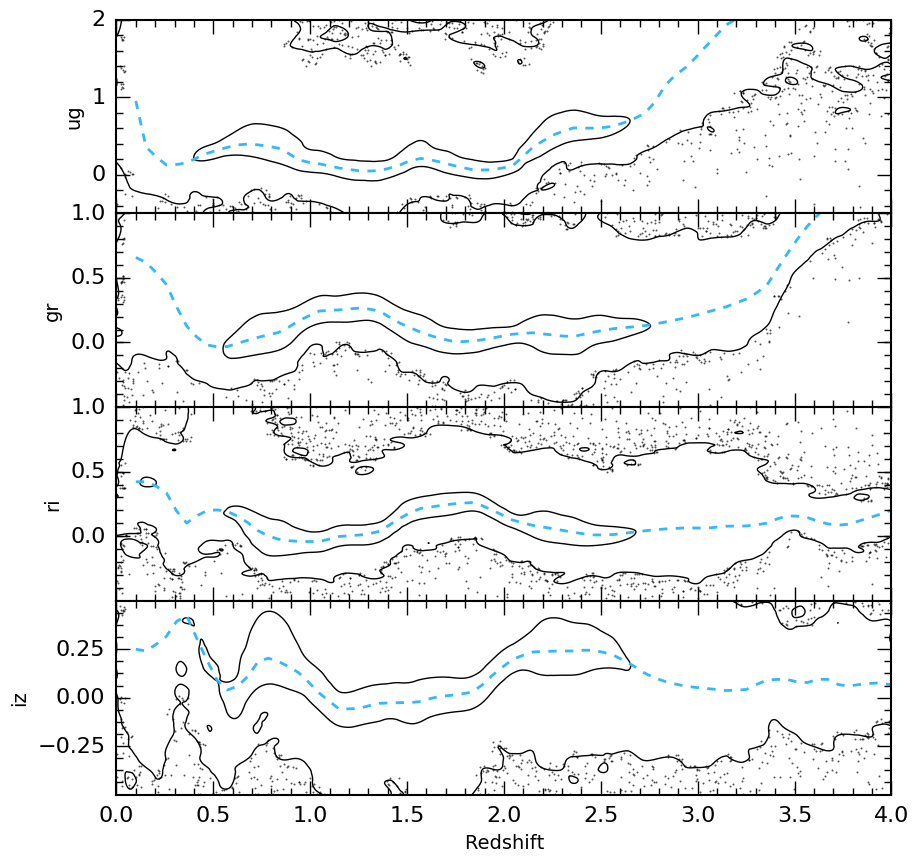

In [9]:
import matplotlib.pyplot as plt

#Plot for paper
fig = plt.figure(2,figsize = (10,10))
gs = gridspec.GridSpec(4, 1)#, width_ratios=[1,1])#,1,1,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharex = ax0)
ax2 = plt.subplot(gs[2],sharex = ax1)
ax3 = plt.subplot(gs[3],sharex = ax2)


plt.axes(ax0)
hex_contour(qdata['zspec'],qdata['ug'], levels=[0.5,0.99], std=True, min_cnt=7, smoothing=4, hkwargs={'gridsize':75}, skwargs={'color':'k','alpha':0.5,'marker':'.'}, ckwargs={'colors':'k','alpha':1,'linewidths':1})
plt.plot(np.linspace(0.1,5.3,100),modeug, linewidth = 2,linestyle = '--', color = '#33B8FF')
#plt.scatter(testdatacand['zbest'],testdatacand['ug'],s = 1, color = '#fd8d3c',alpha = 0.5, zorder = 100)
ax0.set_xlim(0,4)
ax0.yaxis.set_ticks([0,1,2])
ax0.set_ylabel('ug',fontsize = 14)
ax0.set_ylim(-0.5,2)

plt.axes(ax1)
hex_contour(qdata['zspec'],qdata['gr'], levels=[0.5,0.99], std=True, min_cnt=7, smoothing=4, hkwargs={'gridsize':75}, skwargs={'color':'k','alpha':0.5,'marker':'.'}, ckwargs={'colors':'k','alpha':1,'linewidths':1})
plt.plot(np.linspace(0.1,5.3,100),modegr, linewidth = 2,linestyle = '--', color = '#33B8FF')
#plt.scatter(testdatacand['zbest'],testdatacand['gr'],s = 1, color = '#fd8d3c',alpha = 0.255, zorder = 100)
#ax1.set_xlim(0,6)
ax1.yaxis.set_ticks([0,0.5,1])
ax1.set_ylabel('gr',fontsize = 14)
ax1.set_ylim(-0.5,1)


plt.axes(ax2)
hex_contour(qdata['zspec'],qdata['ri'], levels=[0.5,0.99], std=True, min_cnt=7, smoothing=4, hkwargs={'gridsize':75}, skwargs={'color':'k','alpha':0.5,'marker':'.'}, ckwargs={'colors':'k','alpha':1,'linewidths':1})
plt.plot(np.linspace(0.1,5.3,100),moderi, linewidth = 2,linestyle = '--', color = '#33B8FF')
#plt.scatter(testdatacand['zbest'],testdatacand['ri'],s = 1, color = '#fd8d3c',alpha = 0.5, zorder = 100)
#ax2.set_xlim(0,6)
ax2.yaxis.set_ticks([0,0.5,1])
ax2.set_ylabel('ri',fontsize = 14)
ax2.set_ylim(-0.5,1)


plt.axes(ax3)
hex_contour(qdata['zspec'],qdata['iz'], levels=[0.5,0.99], std=True, min_cnt=7, smoothing=4, hkwargs={'gridsize':75}, skwargs={'color':'k','alpha':0.5,'marker':'.'}, ckwargs={'colors':'k','alpha':1,'linewidths':1})
plt.plot(np.linspace(0.1,5.3,100),modeiz, linewidth = 2,linestyle = '--', color = '#33B8FF')
#plt.scatter(testdatacand['zbest'],testdatacand['iz'],s = 1, color = '#fd8d3c',alpha = 0.5, zorder = 100)
#ax3.set_xlim(0,6)
ax3.yaxis.set_ticks([-0.25,0,0.25])
ax3.set_ylabel('iz',fontsize = 14)
ax3.set_ylim(-0.5,0.5)



plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)


#fig.tight_layout()
plt.xlabel('Redshift',fontsize = 14)
#plt.savefig('mode_col_specz.png',bbox_inches='tight')
plt.show()

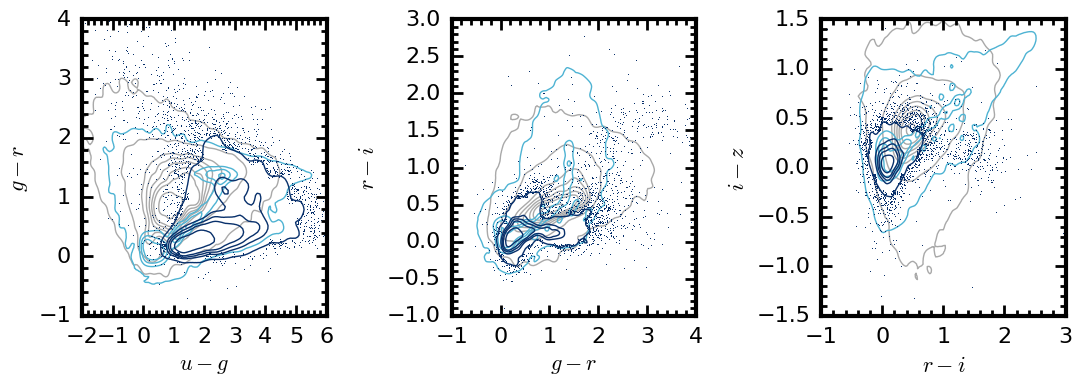

In [10]:
#Color-color Plot for paper
params = {'legend.fontsize': 12, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'xtick.major.width':2, 'xtick.minor.width':2, 'ytick.major.width':2, 'ytick.minor.width':2, 'xtick.major.size':8, 'xtick.minor.size':4, 'ytick.major.size':8, 'ytick.minor.size':4}
plt.rcParams.update(params)
plt.rc("axes", linewidth=3.0)

lowz = qdata['zspec']<=2.25
midz = (qdata['zspec']>2.25)&(qdata['zspec']<=3.45)
highz= qdata['zspec']>=2.9


fig = plt.figure(12,figsize = (16,16))
gs = gridspec.GridSpec(1, 3, height_ratios=[1,1,1,1,1],width_ratios=[1,1,1,1,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])


plt.axes(ax0)
hex_contour(edata['ug'],edata['gr'], levels=[0.1,0.3,0.4,0.5,0.6,0.7,0.9,0.99], std=True, min_cnt=5, smoothing=2, hkwargs={'gridsize':50}, skwargs={'color':'#A9A9A9','alpha':0.5,'marker':''}, ckwargs={'colors':'#A9A9A9','alpha':1,'linewidths':1})
hex_contour(pdata['ug'],pdata['gr'], levels=[0.3,0.5,0.7,0.99], std=True, min_cnt=5, smoothing=2, hkwargs={'gridsize':50}, skwargs={'color':'#4eb3d3','alpha':0.5,'marker':''}, ckwargs={'colors':'#4eb3d3','alpha':1,'linewidths':1})
hex_contour(qdata['ug'][highz],qdata['gr'][highz], levels=[0.3,0.5,0.6,0.7,0.9], std=True, min_cnt=5, smoothing=2, hkwargs={'gridsize':25}, skwargs={'color':'#08306b','alpha':1,'marker':','}, ckwargs={'colors':'#08306b','alpha':1,'linewidths':1})
#hex_contour(testdatacand['ug'],testdatacand['gr'], levels=[0.1,0.2,0.3,0.4,0.5,0.6], std=True, min_cnt=5, smoothing=2, hkwargs={'gridsize':25}, skwargs={'color':'#fd8d3c','alpha':0.5,'marker':'.'}, ckwargs={'colors':'#fd8d3c','alpha':1,'linewidths':1})

ax0.set_xlim(-2,6)
ax0.set_ylim(-1,4)
ax0.set_xlabel(r'$u - g$',fontsize = 16)
ax0.set_ylabel(r'$g - r$',fontsize = 16)
ax0.minorticks_on()

plt.axes(ax1)
hex_contour(edata['gr'],edata['ri'], levels=[0.1,0.3,0.4,0.5,0.6,0.7,0.9,0.99], std=True, min_cnt=5, smoothing=2, hkwargs={'gridsize':50}, skwargs={'color':'#A9A9A9','alpha':0.5,'marker':''}, ckwargs={'colors':'#A9A9A9','alpha':1,'linewidths':1})
hex_contour(pdata['gr'],pdata['ri'], levels=[0.3,0.5,0.7,0.99], std=True, min_cnt=30, smoothing=5, hkwargs={'gridsize':50}, skwargs={'color':'#4eb3d3','alpha':0.5,'marker':''}, ckwargs={'colors':'#4eb3d3','alpha':1,'linewidths':1})
hex_contour(qdata['gr'][highz],qdata['ri'][highz], levels=[0.3,0.5,0.6,0.7,0.9], std=True, min_cnt=5, smoothing=2, hkwargs={'gridsize':50}, skwargs={'color':'#08306b','alpha':1,'marker':','}, ckwargs={'colors':'#08306b','alpha':1,'linewidths':1})
#hex_contour(testdatacand['gr'],testdatacand['ri'], levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.75], std=True, min_cnt=5, smoothing=2, hkwargs={'gridsize':25}, skwargs={'color':'#fd8d3c','alpha':0.5,'marker':'.'}, ckwargs={'colors':'#fd8d3c','alpha':1,'linewidths':1})

ax1.set_xlim(-1,4)
ax1.set_ylim(-1,3)
ax1.set_xlabel(r'$g - r$',fontsize = 16)
ax1.set_ylabel(r'$r - i$',fontsize = 16)
ax1.minorticks_on()

plt.axes(ax2)
hex_contour(edata['ri'],edata['iz'], levels=[0.1,0.3,0.4,0.5,0.6,0.7,0.9,0.99], std=True, min_cnt=5, smoothing=2, hkwargs={'gridsize':50}, skwargs={'color':'#A9A9A9','alpha':0.5,'marker':''}, ckwargs={'colors':'#A9A9A9','alpha':1,'linewidths':1})
hex_contour(pdata['ri'],pdata['iz'], levels=[0.3,0.5,0.7,0.99], std=True, min_cnt=5, smoothing=2, hkwargs={'gridsize':50}, skwargs={'color':'#4eb3d3','alpha':0.5,'marker':''}, ckwargs={'colors':'#4eb3d3','alpha':1,'linewidths':1})
hex_contour(qdata['ri'][highz],qdata['iz'][highz], levels=[0.3,0.5,0.6,0.7,0.9], std=True, min_cnt=5, smoothing=2, hkwargs={'gridsize':50}, skwargs={'color':'#08306b','alpha':1,'marker':','}, ckwargs={'colors':'#08306b','alpha':1,'linewidths':1})
#hex_contour(testdatacand['ri'],testdatacand['iz'], levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.75], std=True, min_cnt=5, smoothing=2, hkwargs={'gridsize':25}, skwargs={'color':'#fd8d3c','alpha':0.5,'marker':'.'}, ckwargs={'colors':'#fd8d3c','alpha':1,'linewidths':1})

ax2.set_xlim(-1,3)
ax2.set_ylim(-1.5,1.5)
ax2.set_xlabel(r'$r - i$',fontsize = 16)
ax2.set_ylabel(r'$i - z$',fontsize = 16)
ax2.xaxis.set_ticks([-1,0,1,2,3])
ax2.minorticks_on()

fig.tight_layout()
#plt.savefig('./Paper_plots/opt_train_colors.pdf',bbox_inches='tight')
plt.show()



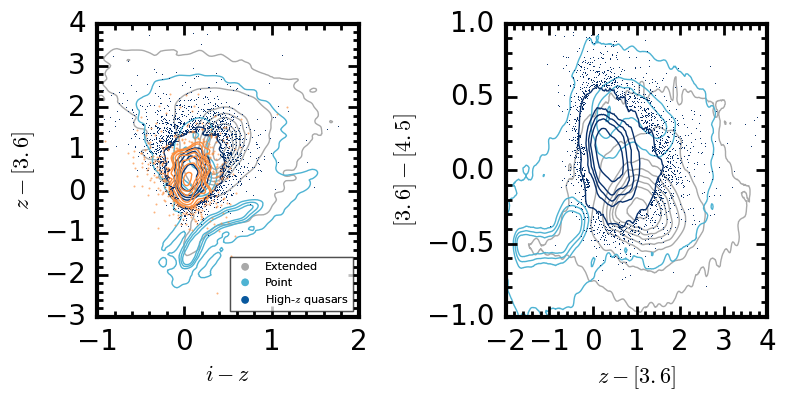

In [20]:
#Plot the infrared
highz= qdata['zspec']>=2.9

fig = plt.figure(13,figsize = (16,16))
gs = gridspec.GridSpec(1, 2, height_ratios=[1,1,1,1,1],width_ratios=[1,1,1,1,1])
ax3 = plt.subplot(gs[0])
ax4 = plt.subplot(gs[1])

plt.axes(ax3)
hex_contour(edata['iz'],edata['zs1'], levels=[0.1,0.3,0.4,0.5,0.6,0.7,0.9,0.99], std=True, min_cnt=5, smoothing=2, hkwargs={'gridsize':50}, skwargs={'color':'#A9A9A9','alpha':0.5,'marker':''}, ckwargs={'colors':'#A9A9A9','alpha':1,'linewidths':1})
hex_contour(pdata['iz'],pdata['zs1'], levels=[0.3,0.5,0.7,0.99], std=True, min_cnt=5, smoothing=2, hkwargs={'gridsize':50}, skwargs={'color':'#4eb3d3','alpha':0.5,'marker':''}, ckwargs={'colors':'#4eb3d3','alpha':1,'linewidths':1})
hex_contour(qdata['iz'][highz],qdata['zs1'][highz], levels=[0.3,0.5,0.6,0.7,0.9], std=True, min_cnt=5, smoothing=2, hkwargs={'gridsize':50}, skwargs={'color':'#08306b','alpha':1,'marker':','}, ckwargs={'colors':'#08306b','alpha':1,'linewidths':1})
#hex_contour(testdatacand['iz'],testdatacand['zs1'], levels=[0.1,0.3,0.4,0.5,0.6,0.7,0.75], std=True, min_cnt=5, smoothing=2, hkwargs={'gridsize':25}, skwargs={'color':'#fd8d3c','alpha':0.5,'marker':'.'}, ckwargs={'colors':'#fd8d3c','alpha':1,'linewidths':1})

eleg = plt.scatter(100,100,color = '#A9A9A9',label = 'Extended')
pleg = plt.scatter(100,100,color = '#4eb3d3',label = 'Point')
hleg = plt.scatter(100,100,color = '#08589e',label = r'High-$z$ quasars')
#cleg = plt.scatter(100,100,color = '#fd8d3c',label = 'Our Candidates')

#first_legend = plt.legend(handles=[eleg,pleg,hleg], scatterpoints = 1, loc = 4,fontsize = 8)
first_legend = plt.legend(handles=[eleg,pleg,hleg,cleg], scatterpoints = 1, loc = 4,fontsize = 8)


first_legend.get_frame().set_alpha(0.5)

ax3.set_xlim(-1,2)
ax3.set_ylim(-3,4)
ax3.set_xlabel(r'$i - z$',fontsize = 16)
ax3.set_ylabel(r'$z - [3.6]$',fontsize = 16)
ax3.xaxis.set_ticks([-1,0,1,2])
ax3.minorticks_on()
plt.gca().add_artist(first_legend)

plt.axes(ax4)
hex_contour(edata['zs1'],edata['s1s2'], levels=[0.1,0.3,0.4,0.5,0.6,0.7,0.9,0.99], std=True, min_cnt=5, smoothing=2, hkwargs={'gridsize':50}, skwargs={'color':'#A9A9A9','alpha':0.5,'marker':''}, ckwargs={'colors':'#A9A9A9','alpha':1,'linewidths':1})
hex_contour(pdata['zs1'],pdata['s1s2'], levels=[0.3,0.5,0.7,0.99], std=True, min_cnt=5, smoothing=2, hkwargs={'gridsize':50}, skwargs={'color':'#4eb3d3','alpha':0.5,'marker':''}, ckwargs={'colors':'#4eb3d3','alpha':1,'linewidths':1})
hex_contour(qdata['zs1'][highz],qdata['s1s2'][highz], levels=[0.3,0.5,0.6,0.7,0.9], std=True, min_cnt=5, smoothing=1, hkwargs={'gridsize':25}, skwargs={'color':'#08306b','alpha':1,'marker':','}, ckwargs={'colors':'#08306b','alpha':1,'linewidths':1})
#hex_contour(testdatacand['zs1'],testdatacand['s1s2'], levels=[0.1,0.3,0.4,0.5,0.6,0.7,0.8], std=True, min_cnt=5, smoothing=2, hkwargs={'gridsize':25}, skwargs={'color':'#fd8d3c','alpha':0.5,'marker':'.'}, ckwargs={'colors':'#fd8d3c','alpha':1,'linewidths':1})

ax4.set_xlim(-2,4)
ax4.set_ylim(-1,1)
ax4.set_xlabel(r'$z - [3.6]$',fontsize = 16)
ax4.set_ylabel(r'$[3.6] - [4.5]$',fontsize = 16)
ax4.minorticks_on()


fig.tight_layout()
#plt.savefig('./Revised_Plots/f5b.pdf',bbox_inches='tight')
plt.show()

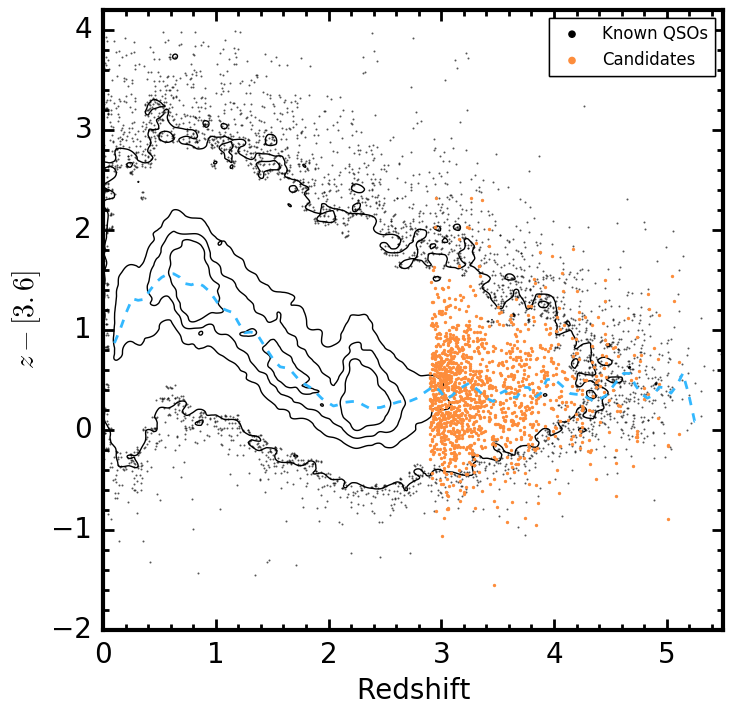

In [19]:
#Single color plot
#Plotting Parameters (Replace with Group code call!)
params = {'legend.fontsize': 12, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'xtick.major.width':2, 'xtick.minor.width':2, 'ytick.major.width':2, 'ytick.minor.width':2, 'xtick.major.size':8, 'xtick.minor.size':4, 'ytick.major.size':8, 'ytick.minor.size':4}
plt.rcParams.update(params)
plt.rc("axes", linewidth=3.0)

fig = plt.figure(3,figsize = (8,8))
hex_contour(qdata['zspec'],qdata['zs1'], levels=[0.25,0.5,0.75,0.99], std=True, min_cnt=7, smoothing=4, hkwargs={'gridsize':75}, skwargs={'color':'k','alpha':0.5,'marker':'.'}, ckwargs={'colors':'k','alpha':1,'linewidths':1})
plt.scatter(testdatacand['zbest'],testdatacand['zs1'],s = 2, color = '#fd8d3c',alpha = 1, zorder = 100)
plt.plot(np.linspace(0.1,5.3,100),modezc1, linewidth = 2,linestyle = '--', color = '#33B8FF',zorder = 200)
know = plt.scatter(100,100,color = 'k')
cand = plt.scatter(100,100,color = '#fd8d3c')
plt.xlim(0,5.5)
plt.ylim(-2,4.2)
#plt.yaxis.set_ticks([-1,0,1,2,3])
plt.ylabel(r'$z - [3.6]$',fontsize = 20)
plt.xlabel('Redshift',fontsize = 20)
first_legend = plt.legend([know,cand],['Known QSOs','Candidates'], loc=1,scatterpoints = 1)
plt.gca().add_artist(first_legend)
#plt.savefig('./Revised_Plots/f4.pdf',bbox_inches='tight')
plt.show()

# Plot the Redshift distribution of the candidates

(1126, 1)
[ 2.90093876  2.90290237  2.90486598 ...,  5.10607291  5.10803652
  5.11000013]
done
(0.9690504744947835, 0.0012292827514336288)
3.23125772482
3.39177533499
5.23000001907
0.125894832963
iqr, 75= 3.6426807218 25= 3.04810908905
higherr= 0.25090538681 lowerr= 0.343666245934


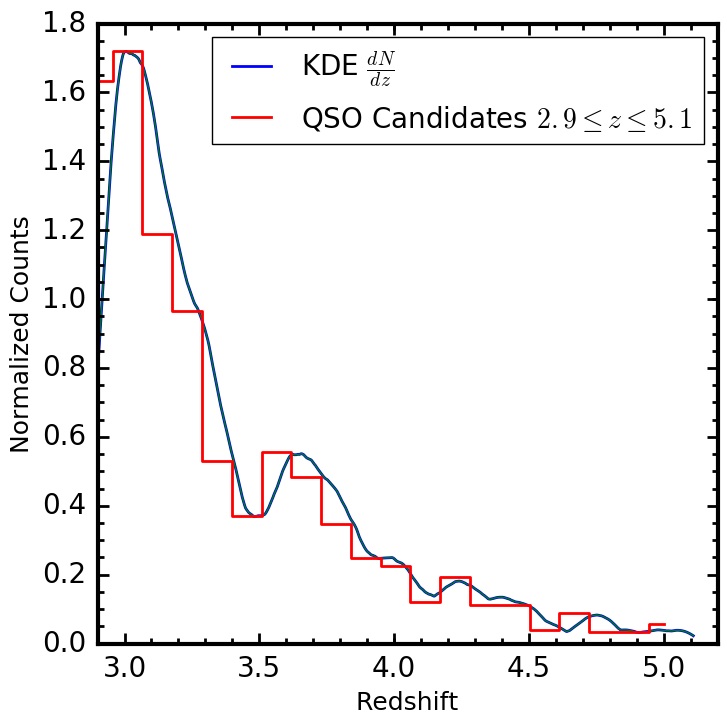

In [13]:
#Import SpIES / SHELA data
data = '/Users/johntimlin/Complete_Clustering_Analysis/Clustering/Data_sets/HZLZ_combined_all_hzclassifiers_wphotoz_zspecflg.fits'
obs = pf.open(data)[1].data
Z = obs.zbest
imag = -2.5/np.log(10) * (np.arcsinh((obs.iflux/1e9)/(2*1.8e-10))+np.log(1.8e-10)) 

gdx = ((Z >= 2.9)&(Z <= 5.2) & (obs.dec>=-1.2) & (obs.dec<=1.2)) & ((obs.ra>=344.4)|(obs.ra<60))&(imag>=20.2)
#gdx = ((Z >= 2.9)&(Z <= 3.4) & (obs.Good_obj == 0)) & (obs.dec>=-1.2) & (obs.dec<=1.2)
#gdx = ((Z >= 3.4)&(Z <= 5.2) & (obs.Good_obj == 0)) & (obs.dec>=-1.2) & (obs.dec<=1.2)

#gdx = Z>0
#Set up a KDE for dNdz
tmpz = Z[gdx][:, np.newaxis] #change the array from row shape (1) to column shape (1,)
print np.shape(tmpz)
sample_range = np.linspace(min(tmpz[:, 0]), max(tmpz[:, 0]), len(tmpz[:, 0]))[:, np.newaxis]

est = kde(bandwidth=0.1,kernel='epanechnikov') #Set up the Kernel

histkde = est.fit(tmpz).score_samples(sample_range) #fit the kernel to the data and find the density of the grid
#Interpolate (you get the same function back) to plug in any z in the range (as opposed to set z values)
dNdz = interpolate.interp1d(sample_range.flatten(),np.exp(histkde))
print sample_range.flatten()
print 'done'
ZE = np.linspace(min(Z),max(Z),100)
xo=integrate.quad(dNdz,min(sample_range),max(sample_range)) #quad(f(x),xlower,xupper, args)
print xo
print np.median(Z[gdx])
print np.mean(Z[gdx])
print np.max(Z)
print np.min(Z)

#Plotting Parameters (Replace with Group code call!)
#params = {'legend.fontsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'xtick.major.width':2, 'xtick.minor.width':2, 'ytick.major.width':2, 'ytick.minor.width':2, 'xtick.major.size':8, 'xtick.minor.size':6, 'ytick.major.size':8, 'ytick.minor.size':6}
#plt.rcParams.update(params)
#plt.rc("axes", linewidth=3.0)


num,bins = np.histogram(Z[gdx],bins='fd',normed=True)

#Compute the redshift percentiles for the Friedmann-Diaconis rule for bin width
q75, q25 = np.percentile(obs.zbest[gdx], [75 ,25])

print 'iqr, 75=',q75,'25=', q25

print "higherr=", q75 - np.mean(Z[gdx]),"lowerr=", np.mean(Z[gdx])-q25
#iqr = q75 - q25
#FD = 2*iqr /(len(obs.ZSPEC[gdx]))**(1/3.0)
#Set up the bin range from using the Friedmann Diaconis bin width
#bins = np.arange(min(obs.ZSPEC[gdx]),max(obs.ZSPEC[gdx]),FD)


#Plot the KDE dndz
plt.figure(1,figsize = [8,8])
plt.plot(sample_range[:,0],np.exp(histkde),linewidth = 2, label = r'KDE $\frac{dN}{dz}$')
plt.plot(sample_range[:,0],dNdz(sample_range[:,0]))
plt.plot(bins[:-1],num,linestyle = 'steps-mid',linewidth = 2, label=r'QSO Candidates $2.9 \leq z \leq 5.1$')
#ZE = np.linspace(min(Z),max(Z),100)
#xo=integrate.quad(dNdz,min(sample_range),max(sample_range)) #quad(f(x),xlower,xupper, args)
#print xo
plt.xlim(2.9,5.2)
plt.xlabel('Redshift',fontsize = 18)
plt.ylabel('Normalized Counts',fontsize = 18)
plt.legend(fontsize=20)
#plt.savefig('./Paper_plots/dndz.pdf')
plt.show() 

# Look at the absolute magnitude of the candidates

In [14]:
data = obs
rshift = data.zbest[(data.zbest >=2.9) & (data.dec<=1.2) & (data.dec>=-1.2)& ((data.ra>=344.4)|(data.ra<60))]

print rshift.dtype
r = rshift.astype('float64') #camb's luminosity distance calculator only accepts float 64 data types
print r.dtype
ash_m = -2.5/np.log(10) * (np.arcsinh((data.iflux[(data.zbest >=2.9) & (data.dec<=1.2) & (data.dec>=-1.2)& ((data.ra>=344.4)|(data.ra<60))]/1e9)/(2*1.8e-10))+np.log(1.8e-10)) 
print ash_m


>f8
float64
[ 17.86406282  21.83530584  21.3531761  ...,  21.32508453  21.8789699
  21.81445908]


In [15]:
#Open the Shen2007 data
shendat = './Shen2007_Clustering_sample.fits'
sdat = pf.open(shendat)[1].data
#Cut to their objects and get array of redshifts
sdx = (sdat.Sfl == 1) #& (sdat.z>=3.5) & (sdat.z<=5.4)
srz = sdat.z[sdx]
sr = srz.astype('float64')
#print simag

In [16]:
#First define Planck 2015 cosmological parameters
H = 70 #H0. 
oc = 0.229 #physical density of CDM 
ob = 0.046 #physical density of baryons
#Set up parameters in CAMB
pars = camb.CAMBparams()
#Conversion to density param: Omega_Matter = (oc+ob)/(H0/100.)**2
#Hard code the cosmolgy params
pars.H0=H #hubble param (No h!!)
pars.omegab=ob #Baryon density parameter
pars.omegac=oc #CDM density parameter
pars.omegav=0.725 #Vacuum density parameter
pars.set_dark_energy()

#Set up parameters in CAMB
pars = camb.CAMBparams()
#H0 is hubble parameter at z=0, ombh2 is the baryon density (physical), omch2 is the matter density (physical)
#mnu is sum of neutrino masses, omk is curvature parameter (set to 0 for flat), meffsterile is effective mass of sterile neutrinos
pars.set_cosmology(H0=H,ombh2=ob, omch2=oc,omk=0)#,mnu=0,meffsterile=0) 
pars.set_dark_energy()

bkg = camb.get_background(pars) #Background parameters 


Ldist = bkg.luminosity_distance(r) #Luminosity distance for SpIES cand
ShLdist = bkg.luminosity_distance(sr) #Luminosity distance for Shen qso


#Make the i_mag line targeted for shen 2007
sampz = np.linspace(0.5,5.4,10000)
line = bkg.luminosity_distance(sampz)
const_mag = np.ones(len(line))*20.2
const_magsp = np.ones(len(line))*22.5

In [17]:
#Compute the absolute magnitude at z=0
#M = (22.5-2.5*np.log10(data.iflux[rz])) - 5.0*np.log10(Ldist) - 25.0
M = ash_m - 5.0*np.log10(Ldist) - 25.0
M202 = const_mag - 5.0*np.log10(line) - 25.0
M23 = const_magsp - 5.0*np.log10(line) - 25.0
shenM = sdat['imag'][sdx] - 5.0*np.log10(ShLdist) - 25.0

In [18]:
#Compute the corrections to apply to M[z=0] to get M[z=2]
def Kcorr(z,alpha = -0.5):
    #Ross13
    K13 = -2.5*np.log10(1+z) - 2.5*alpha*np.log10(1+z)+2.5*alpha*np.log10(1.0+2.0)
    return K13
#import the K-corrections from Richards 2006
K06 = pf.open('../Absolute_magnitude/K_correct_Richards06.fits')[1].data
K13 = pf.open('../Absolute_magnitude/K_correct_Ross13.fits')[1].data

#Pull out the redshift information from the data for SpIES and Shen
rshifts = data.zbest[(data.zbest >=2.9) & (data.dec<=1.2) & (data.dec>=-1.2)& ((data.ra>=344.4)|(data.ra<60))]
srshift = sdat.z[sdx]

#Round the redshifts to 2 decimal places so that I can match to the correction values in Richards 2006
roundz = np.round(rshifts,decimals = 2)
roundt = np.round(sampz,decimals = 2)
roundsz = np.round(srshift,decimals = 2)

#Find the correction value that corresponds to the redshift in the file
Kcor=[]
Ktest = []
Ktestsp = []
Kshen = []
for i in roundz:
    kc = K06.KCorr[np.where(K06.z == i)]
    if len(kc) == 1:
        Kcor.append(kc[0])
    else:
        Kcor.append(0)
        
for j in roundt:
    kt = K06.KCorr[np.where(K06.z == j)] 
    Ktest.append(kt[0])
    Ktestsp.append(kt[0])

for m in roundsz:
    kt = K06.KCorr[np.where(K06.z == j)] 
    Kshen.append(kt[0])


KC = np.asarray(Kcor)
KT = np.asarray(Ktest)
KS = np.asarray(Kshen)

#Correct the Absolute values using the K-corrections found above
dcorrect = M-KC
lcorrect = M202-Ktest
spcorrect= M23 - Ktestsp
scorrect = shenM - Kshen



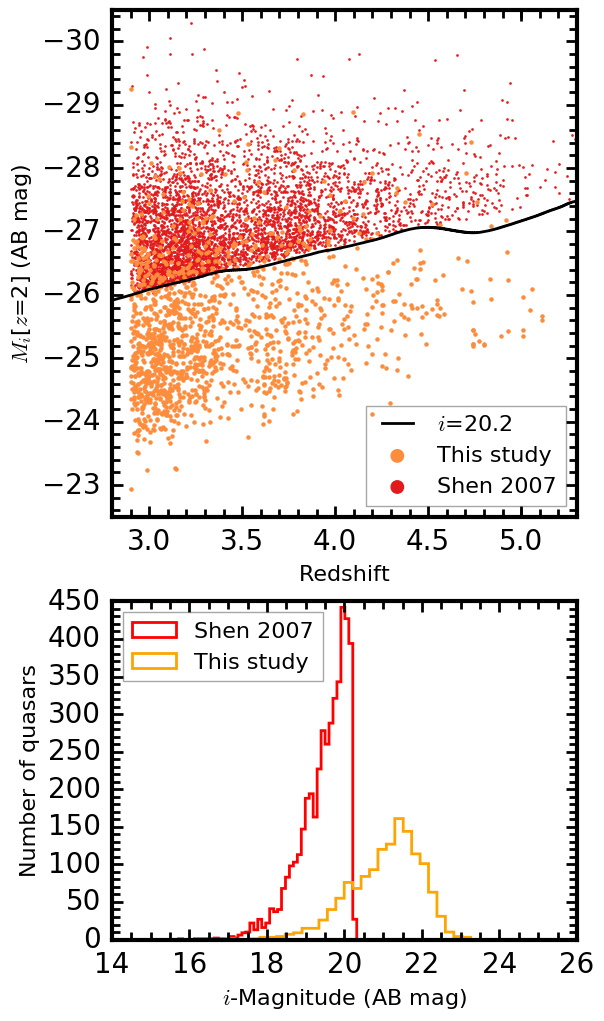

In [19]:
#Plotting Parameters (Replace with Group code call!)
params = {'legend.fontsize': 16, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'xtick.major.width':2, 'xtick.minor.width':2, 'ytick.major.width':2, 'ytick.minor.width':2, 'xtick.major.size':8, 'xtick.minor.size':6, 'ytick.major.size':8, 'ytick.minor.size':6}
plt.rcParams.update(params)
plt.rc("axes", linewidth=3.0)
imag = ash_m = -2.5/np.log(10) * (np.arcsinh((data.iflux[(data.zbest >=2.9) & (data.dec<=1.2) & (data.dec>=-1.2)& ((data.ra>=344.4)|(data.ra<60))]/1e9)/(2*1.8e-10))+np.log(1.8e-10)) 

num,bins = np.histogram(imag,bins='fd')

fig = plt.figure(5,figsize = (6,12))
gs = gridspec.GridSpec(2, 1, height_ratios=[0.6,0.4])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],)

plt.axes(ax0)

plt.scatter(rshift,dcorrect,color = '#fd8d3c',edgecolor = None,s=5,zorder=100,alpha = 1)#,label = 'Timlin 2016 QSO sample' )
plt.scatter(1,1,s=80,color = '#fd8d3c',label = 'This study')
plt.scatter(srz,scorrect,color='#e31a1c',edgecolor = None,s=1,alpha = 0.9)#,label = 'Shen 2007 QSO sample')
plt.scatter(1,1,s=80,color = '#e31a1c',label = 'Shen 2007')
plt.plot(sampz,lcorrect,color = 'k',linewidth = 2,zorder=101,label = r'$i$=20.2')
#plt.plot(sampz,spcorrect,color = 'k',linestyle = '--', dashes=(10,5,10,5),linewidth = 2,label = r'$i$=23.3')
plt.xlim(2.8,5.3)
plt.ylim(-30.5,-22.5)
plt.xlabel('Redshift',fontsize = 16)
plt.ylabel(r'$M_i$[$z$=2] (AB mag)',fontsize = 16)
plt.gca().invert_yaxis()
plt.minorticks_on()
leg =plt.legend(loc=4,scatterpoints = 1)
leg.get_frame().set_alpha(0.35)

plt.axes(ax1)
plt.hist(sdat['imag'][sdx],bins='fd', histtype = 'step',normed = False,color = 'r',linewidth = 2,label= 'Shen 2007')
plt.hist(imag,bins, histtype = 'step',normed = False,color = '#FFA500',linewidth = 2,label = 'This study')
ax1.set_xlim(14,26)


plt.xlabel(r'$i$-Magnitude (AB mag)',fontsize = 16)
plt.ylabel('Number of quasars',fontsize = 16)
plt.minorticks_on()
leg =plt.legend(loc=2)
leg.get_frame().set_alpha(0.35)

#plt.savefig('./Paper_plots/Absolute_Mag_SpIES_Shen.pdf',bbox_inches='tight',pad_inches=0.5)


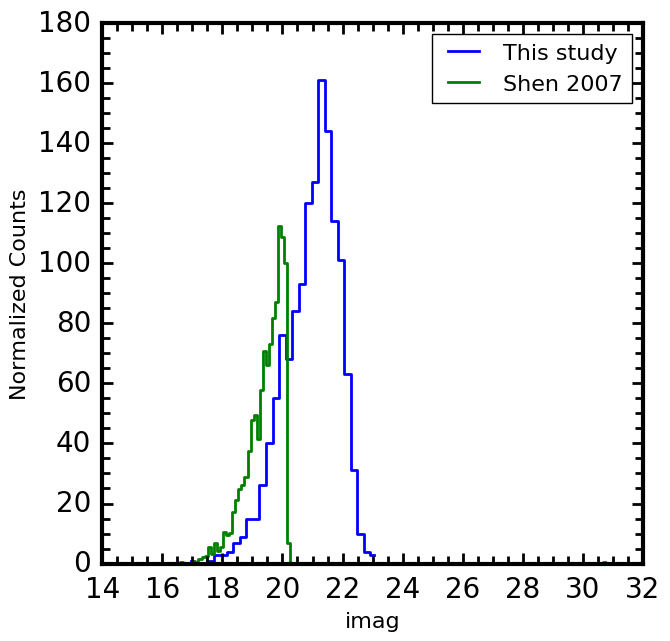

In [20]:
##Plot the redshift histograms

num,bins2 = np.histogram(imag,bins='fd')#,normed=True)
snum,sbins = np.histogram(sdat['imag'][sdx],bins='fd')#,normed=True)

snum = snum * len(Z[gdx])/float(len(sr))

#snum = snum / 4000.
#num = num/ 120.

plt.figure(6)
plt.plot(bins2[:-1],num,linestyle='steps-mid',linewidth = 2,label = 'This study')
plt.plot(sbins[:-1],snum,linestyle='steps-mid', linewidth = 2, label='Shen 2007')
plt.xlabel('imag')
plt.ylabel('Normalized Counts')
plt.legend()

# Plot the CF and the bias

In [21]:
#Generate the covariance matrix from the Jackknife file
def make_covariance(Jackfile, warray, RRarray):
    JK_xi = []
    size = float(len(warray))
    jkdat = open(Jackfile,'rw')
    #Read the header of the jackknife file and assign the number of jackknife resamples done for the sample
    jkhead = jkdat.readline()
    print jkhead
    jknum= np.float(jkhead.split()[7])
    #Pull out the proper info from the file (RR,Xi,etc.) for each jackknife and put into array
    RRjk = np.zeros([int(jknum),int(size)])
    Xijk = np.zeros([int(jknum),int(size)])
    Thjk = np.zeros([int(jknum),int(size)])
    
    num=jkdat.readlines()
    row = 0
    k=0

    for j in range(len(num)):
        #At the end of a Jackknife run, I create a new line called 'STEP_DONE' which tells me that my next JK routine is running and separates the two.
        if num[j].split()[0] == 'STEP_DONE':
            row +=1
            k=0
        #For each of the JK runs, append the info into arrays
        else:
            Thjk[row,k] = float(num[j].split()[0])
            RRjk[row,k] = float(num[j].split()[3])
            Xijk[row,k] = float(num[j].split()[4])
            k+=1
    C = np.zeros([len(RRjk[0]),len(RRjk[0])])
    for m in range(len(RRjk[0])):
        for n in range(len(RRjk[0])):
            left = np.sqrt(np.asarray(RRjk[:,m])/RRarray[m])
            dwa = np.asarray(Xijk[:,m]) - warray[m]
            right = np.sqrt(np.asarray(RRjk[:,n])/RRarray[n])
            dwb = np.asarray(Xijk[:,n]) - warray[n]
            val = left*dwa*right*dwb
            C[m,n] = sum(val)
    return C

#Generate the covariance matrix from the Jackknife file
def make_JKxi(Jackfile, warray, RRarray):
    JK_xi = []
    size = float(len(warray))
    jkdat = open(Jackfile,'rw')
    #Read the header of the jackknife file and assign the number of jackknife resamples done for the sample
    jkhead = jkdat.readline()
    jknum= np.float(jkhead.split()[7])
    #Pull out the proper info from the file (RR,Xi,etc.) for each jackknife and put into array
    RRjk = np.zeros([int(jknum),int(size)])
    Xijk = np.zeros([int(jknum),int(size)])
    Thjk = np.zeros([int(jknum),int(size)])
    
    num=jkdat.readlines()
    row = 0
    k=0

    for j in range(len(num)):
        #At the end of a Jackknife run, I create a new line called 'STEP_DONE' which tells me that my next JK routine is running and separates the two.
        if num[j].split()[0] == 'STEP_DONE':
            row +=1
            k=0
        #For each of the JK runs, append the info into arrays
        else:
            Thjk[row,k] = float(num[j].split()[0])
            RRjk[row,k] = float(num[j].split()[3])
            Xijk[row,k] = float(num[j].split()[4])
            k+=1
    JK_xi.append(Xijk)   
    return JK_xi

#Compute chi square
def chisq(dat,mod,cmat):
    x = 0
    inverse = np.linalg.inv(cmat)
    for i in range(len(cmat)):
        for j in range(len(cmat)):
            df1 = dat[i]-mod[i]
            df2 = dat[j]-mod[j]
            #icv = cmat[i,j]**-1
            icv = inverse[i,j]
            x += df1*icv*df2
    return x

#Compute the regression matrix
def Regressmat(covar,theta):
    R= np.zeros([len(theta),len(theta)])
    for i in range(len(theta)):
        for j in range(len(theta)):
            R[i,j] = covar[i,j]/(np.sqrt(covar[i,i])*np.sqrt(covar[j,j]))
    return R

In [22]:
### SPLITTING BY Z Cuting at any imag

#allz= '../Compute_correlation/Extinction_cut_densitycheck15.txt'
allz = '../Compute_correlation2/Final_Clustering_All.txt'


#lowz = '../Compute_correlation/Extinction_cut_densitycheck11.txt'
lowz = '../Compute_correlation2/Final_Clustering_Faint.txt'


#allzJK = '../Compute_correlation/Extinction_cut_densitycheck15_JK.txt'
allzJK = '../Compute_correlation2/Final_Clustering_All_JK.txt'


#lowzJK = '../Compute_correlation/Extinction_cut_densitycheck11_JK.txt'
lowzJK = '../Compute_correlation2/Final_Clustering_Faint_JK.txt'


noextcut = '../Compute_correlation2/Final_Clustering_noextcut.txt'
noextcutJK= '../Compute_correlation2/Final_Clustering_noextcut_JK.txt'
datfiles = [allz,lowz,noextcut]
JKfiles = [allzJK,lowzJK,noextcutJK]

In [23]:
#Loop over the data files list to open and plot the correlation function
separation = []
wnames = []
RRnames = []
DDnames = []
DRnames = []
for infile in datfiles:
    fileopen = open(infile,'rw')
    header = fileopen.readline()
    data = fileopen.readlines() 

    th = []
    w = []
    RR = []
    DD = []
    DR = []
    for i in range(len(data)):
        t = float(data[i].split()[0]) #Theta
        x = float(data[i].split()[4]) #w(theta) 
        rr = float(data[i].split()[3]) #RR 
        dd = float(data[i].split()[1]) #DD
        dr = float(data[i].split()[2]) #DR 
        w.append(x)
        RR.append(rr)
        DD.append(dd)
        DR.append(dr)
        th.append(t)
    #Put the w and RR values into an array to call for Jackknife calculation
    wnames.append(w)
    RRnames.append(RR)
    DDnames.append(DD)
    DRnames.append(DR)
    separation.append(th)

In [24]:
#Compute Jackknife errors from the counts information
sigma = []
covmat = []
for h in range(len(JKfiles)):
    covariance = make_covariance(JKfiles[h], wnames[h], RRnames[h])
    sigma.append(np.diag(covariance))
    covmat.append(covariance)

#Compute the regression matrix
regmat = []
for h in range(len(wnames)):
    regmat.append(Regressmat(covmat[h],th))

print np.shape(JKfiles)

#Get jackknife w's
JK_xi = []
for h in range(len(JKfiles)):
    jk = make_JKxi(JKfiles[h], wnames[h], RRnames[h])
    JK_xi.append(jk[0])

print np.shape(JK_xi)
print len(separation[0])


#Theta DD DR RR XI factor=103.708998549 jknum= 10

#Theta DD DR RR XI factor=126.919182948 jknum= 10

#Theta DD DR RR XI factor=97.7086570477 jknum= 20

(3,)
(3,)
21


In [241]:
#Print values for latex table
pcts = 0
for i in range(len(DDnames[pcts])):
    #print separation[0][i], '&', DDnames[0][i], '&', DRnames[0][i], '&', RRnames[0][i], '&', wnames[0][i], '&', sigma[0][i]
    print '%.3f & %.1i & %.1i & %.1i & %.3f & %.4f \\\\'%(separation[pcts][i],DDnames[pcts][i],DRnames[pcts][i],RRnames[pcts][i],wnames[pcts][i],sigma[pcts][i]**0.5)

0.050 & 0 & 5 & 364 & -1.849 & 1.3754 \\
0.076 & 0 & 7 & 828 & -0.754 & 0.5038 \\
0.116 & 0 & 17 & 1980 & -0.781 & 0.5074 \\
0.175 & 0 & 37 & 4370 & -0.756 & 0.2472 \\
0.266 & 2 & 116 & 10432 & 0.756 & 2.7091 \\
0.403 & 2 & 268 & 23350 & -0.459 & 0.8997 \\
0.611 & 8 & 542 & 53470 & 0.507 & 0.6561 \\
0.927 & 12 & 1162 & 120784 & 0.073 & 0.5107 \\
1.405 & 32 & 2652 & 273444 & 0.247 & 0.3623 \\
2.131 & 74 & 6022 & 619802 & 0.269 & 0.2385 \\
3.231 & 156 & 13782 & 1403064 & 0.158 & 0.1461 \\
4.899 & 324 & 30643 & 3191350 & 0.100 & 0.0680 \\
7.428 & 692 & 69474 & 7209140 & 0.034 & 0.0398 \\
11.262 & 1506 & 155010 & 16201178 & 0.015 & 0.0295 \\
17.075 & 3226 & 343452 & 36027696 & -0.014 & 0.0239 \\
25.889 & 7104 & 747011 & 78725580 & 0.002 & 0.0116 \\
39.253 & 14932 & 1581774 & 166710784 & -0.005 & 0.0088 \\
59.516 & 29674 & 3141776 & 330927082 & -0.005 & 0.0058 \\
90.237 & 53028 & 5579277 & 583004272 & -0.007 & 0.0067 \\
136.818 & 75010 & 7795784 & 815069184 & 0.006 & 0.0048 \\
207.443 & 100

In [26]:
#Following Limber was computed with cosmology (H0,oM,oL)=(70 0.275 0.725)

##This mclimber was done for all objects 2.9<z<5.2 with the final extinction cut
#mclimber_all = [0.0022985455460854311, 0.002190906206060354, 0.0019050009268706861, 0.0014597340543666827, 0.0011930585369182276, 0.0010986709810461117, 0.00094649771865113624, 0.00076558109638027679, 0.00061438375999886519, 0.00044071103670242337, 0.0002922685651020179, 0.0001822212459274252, 9.9271323173412895e-05, 4.6197392904322397e-05, 1.2931319225272703e-05, 4.7453885636605057e-06, -5.7295018738381326e-06, 1.2945112206313357e-06, -2.5558770786635691e-07, 2.0699244496380732e-07]
mclimber_all = [0.0023225429800455637, 0.0021904216380701663, 0.0019131070604180881, 0.0014786904158938835, 0.0011890604062646827, 0.0010940716450842042, 0.00093718770767066959, 0.00076265063034504225, 0.00060422121011192086, 0.00044679016204705126, 0.00030194843029433929, 0.00018166547183924261, 9.4950001759959546e-05, 3.8987292761102685e-05, 1.1656427992710588e-05, 3.8949187589265721e-06, -2.9131135157959959e-06, -1.1865435316490505e-06, -2.3067268951194958e-08, -3.3127561090276543e-07]

#Faint object mclimber with 2.9<z<5.2 with the final extinction cut
#mclimber_low = [0.0023361185250621954, 0.0022064706354088227, 0.0019282439133336759, 0.001482917422530129, 0.0011957113165133413, 0.0011014068340747148, 0.00095946149406393787, 0.0007628377171479422, 0.00061163938639381384, 0.00044805175751709867, 0.00030603189442905508, 0.00018139568437827117, 0.00010018310283104244, 3.6089328262967487e-05, 1.4327521403724255e-05, 2.5924823483705164e-06, -1.7349928197612959e-06, -5.9322324154763784e-07, -1.8647502832907961e-07, -3.2690812395202273e-06]
mclimber_low = [0.0023434681655488164, 0.00220980536106738, 0.0019304367032472322, 0.0014918498380812274, 0.001199407998299017, 0.0011039249516458126, 0.00094488397832085942, 0.00076818403229805582, 0.00060977961027003217, 0.00044978162722766413, 0.00030446958669083705, 0.0001837530609937916, 9.5576443396815135e-05, 3.9697923306540059e-05, 1.1942942460071294e-05, 3.7627680973315105e-06, -2.7558403451147061e-06, -1.3771884816435565e-06, -2.5384149702699815e-07, -1.6631862413132479e-07]

#This mclimber was done for 2.9<z<5.2 with NO extinction cut
mclimber_high = [0.0022431396363423316, 0.0021162407711600136, 0.0018475876015958109, 0.0014284705873674553, 0.0011477142220921229, 0.0010584520197460764, 0.00090569998086366789, 0.00073711419614537932, 0.00058725243468066616, 0.00042998223343848857, 0.00029288227711760491, 0.00017371031323757546, 8.9363275487060279e-05, 3.8516276985481394e-05, 1.1890378726673242e-05, 8.4428691253596875e-07, -4.9585063168790102e-07, -9.6881625471038158e-07, 1.9202865144844596e-07, -1.7224990846038425e-07]

limbera = np.asarray(mclimber_all)*np.pi / 0.7**3 
limberl = np.asarray(mclimber_low)*np.pi / 0.7**3 
limberh = np.asarray(mclimber_high)*np.pi / 0.7**3 

#Interpolate Limber (you get the same function back) to plug in any z in the range (as opposed to set z values)
Limbera = interpolate.interp1d(np.logspace(-1.3,2.5,20),limbera)
Limberl = interpolate.interp1d(np.logspace(-1.3,2.5,20),limberl)
Limberh = interpolate.interp1d(np.logspace(-1.3,2.5,20),limberh)



In [99]:
#COmpute different estimators to comapre to LS

EstDP = 103.708998549*np.asarray(DDnames[0])/np.asarray(DRnames[0]) - 1
EstH  = np.asarray(DDnames[0]) * np.asarray(RRnames[0])/(np.asarray(DRnames[0]))**2 - 1
print EstDP
print EstH
print wnames[0]

[-1.         -1.         -1.         -1.          0.78808618 -0.22605225
  0.53076013  0.07100515  0.25139063  0.27440483  0.17389376  0.09655437
  0.03299978  0.00758501 -0.02587485 -0.01373778 -0.02098355 -0.02047096
 -0.01430225 -0.00212577 -0.01178099]
[-1.         -1.         -1.         -1.          0.55053508 -0.34979951
  0.45613486  0.07344154  0.24414597  0.26474564  0.15233191  0.10117637
  0.03358202  0.01543501 -0.01469939  0.00222407 -0.00506935 -0.00514917
 -0.00683562  0.00599088  0.00222173]
[-1.84914831178, -0.753533791885, -0.780861591239, -0.756170684805, 0.755619737024, -0.459396593668, 0.506712111707, 0.0731136899962, 0.247031479414, 0.268863271815, 0.15843607938, 0.100346430838, 0.0335445121883, 0.0152570497141, -0.0142391858002, 0.00240743978784, -0.00465262688083, -0.00475459191737, -0.00667670043128, 0.00595969651812, 0.0023552869176]


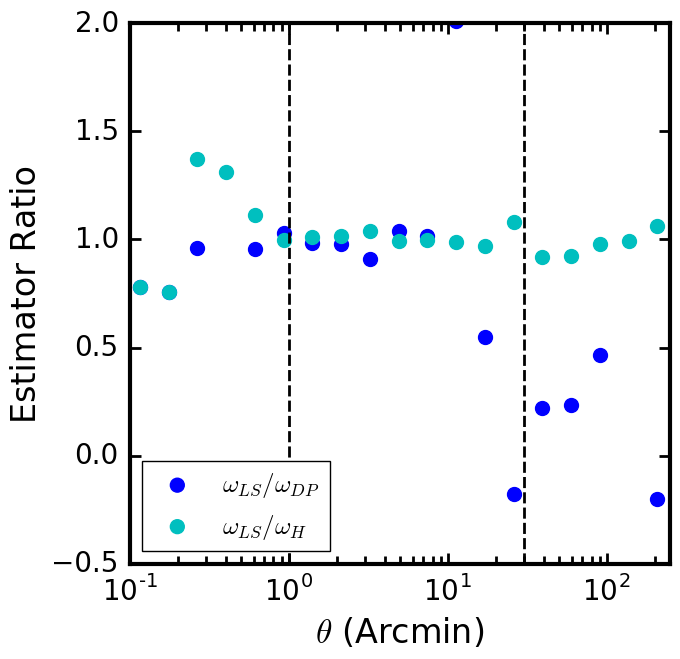

In [100]:
plt.scatter(separation[0],np.asarray(wnames[0])/EstDP,color = 'b', edgecolor = None, s=100, label = r'$\omega_{LS}/\omega_{DP} $')
plt.scatter(separation[0],np.asarray(wnames[0])/EstH,color = 'c', edgecolor = None,s=100, label = r'$\omega_{LS}/\omega_{H} $')

plt.axvline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.axvline(30,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.yscale('linear')
plt.ylabel('Estimator Ratio',fontsize = 24)
plt.ylim(-0.5,2)
plt.xscale('log')
plt.xlim(0.1,250)
plt.xlabel(r'$\theta$ (Arcmin)',fontsize = 24)
plt.legend(loc = 3, fontsize = 18, scatterpoints=1)

/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()
/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide
/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide


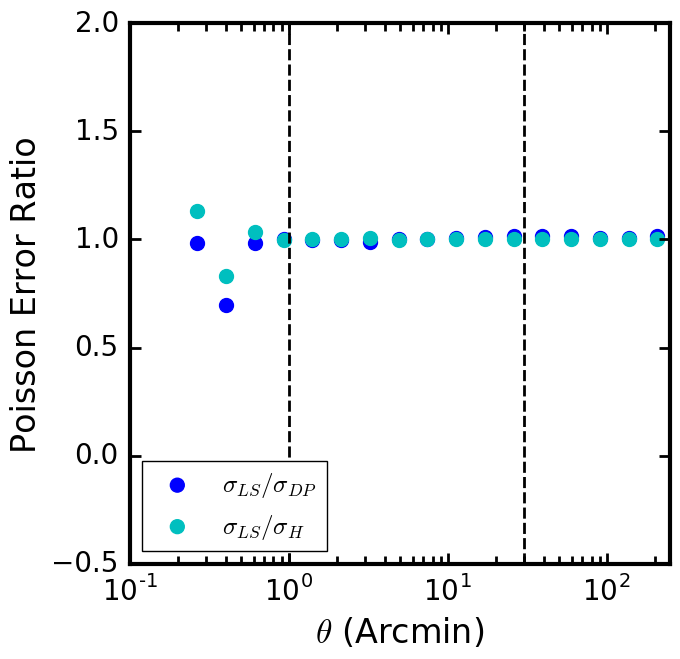

In [115]:
#Poisson Errors:

PoiDP = (1.0 + EstDP) / np.sqrt(np.asarray(DDnames[0]))
PoiDP2 = 103.70899855*np.sqrt(np.asarray(DDnames[0]))/np.asarray(DRnames[0])
PoiH = (1.0 + EstH) / np.sqrt(np.asarray(DDnames[0]))
PoiLS = (1.0 + np.asarray(wnames[0])) / np.sqrt(np.asarray(DDnames[0]))


plt.scatter(separation[0],PoiLS/PoiDP,color = 'b', edgecolor = None, s=100, label = r'$\sigma_{LS}/\sigma_{DP} $')
plt.scatter(separation[0],PoiLS/PoiH,color = 'c', edgecolor = None,s=100, label = r'$\sigma_{LS}/\sigma_{H} $')

plt.axvline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.axvline(30,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.yscale('linear')
plt.ylabel('Poisson Error Ratio',fontsize = 24)
plt.ylim(-0.5,2)
plt.xscale('log')
plt.xlim(0.1,250)
plt.xlabel(r'$\theta$ (Arcmin)',fontsize = 24)
plt.legend(loc = 3, fontsize = 18, scatterpoints=1)


[ 1.37535913  0.50383752  0.50736785  0.24719045  2.70913607  0.89970209
  0.65607754  0.51065806  0.36231157  0.23849587  0.14610923  0.06797061
  0.0398463   0.02948382  0.02394665  0.01156145  0.00883483  0.00580712
  0.00668092  0.00477153  0.00501359]


/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide


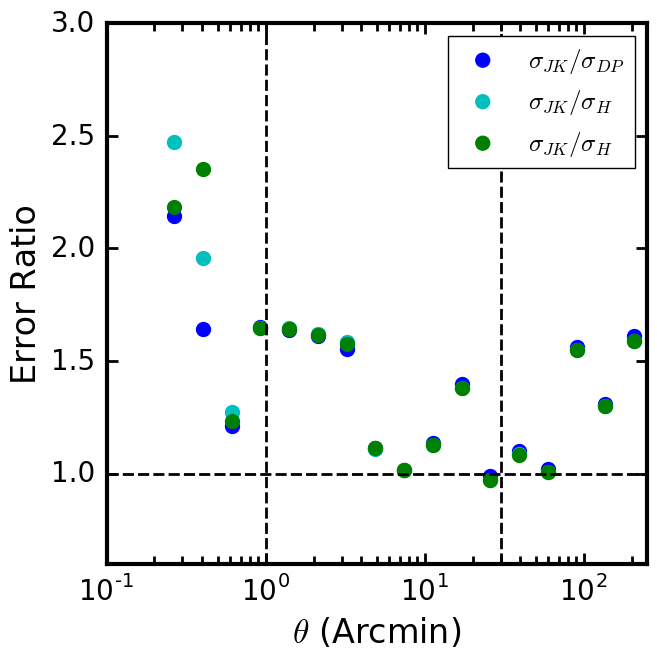

In [121]:
#Poisson to JK error

print sigma[0]**0.5 


plt.scatter(separation[0],sigma[0]**0.5/PoiDP2,color = 'b', edgecolor = None, s=100, label = r'$\sigma_{JK}/\sigma_{DP} $')
plt.scatter(separation[0],sigma[0]**0.5/PoiH,color = 'c', edgecolor = None,s=100, label = r'$\sigma_{JK}/\sigma_{H} $')
plt.scatter(separation[0],sigma[0]**0.5/PoiLS,color = 'g', edgecolor = None,s=100, label = r'$\sigma_{JK}/\sigma_{H} $')

plt.axhline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.axvline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.axvline(30,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.yscale('linear')
plt.ylabel('Error Ratio',fontsize = 24)
plt.ylim(0.6,3)
plt.xscale('log')
plt.xlim(0.1,250)
plt.xlabel(r'$\theta$ (Arcmin)',fontsize = 24)
plt.legend(loc = 1, fontsize = 18, scatterpoints=1)


In [260]:
#Stellar contamination fit using the efficiency of the algorithm (0.86) and the correlation function of stars in the field at large scale (0.09)

def stellar_cont(Limb,b,e):
    w_cont = (0.86**2 *b**2 * Limb) + (0.09*(1-0.86)**2) + e
    #w_cont = (0.93**2 *b**2 * Limb) + (0.09*(1-0.93)**2) + e
    return w_cont

bdx = (np.asarray(separation[0])>1) & (np.asarray(separation[0])<30)& (np.asarray(wnames[0])>0) 

#bdx = (np.asarray(separation[0])>1) & (np.asarray(separation[0])<70)& (np.asarray(wnames[0])>-0.1) 

allzb, allzcov = curve_fit(stellar_cont, np.asarray(Limbera(separation[0])[bdx]), np.asarray(wnames[0])[bdx], sigma = covmat[0][:,bdx][bdx,:],absolute_sigma=True, bounds=([0,0.],[np.inf,np.inf]))
lowzb, lowzcov = curve_fit(stellar_cont, np.asarray(Limberl(separation[1])[bdx]), np.asarray(wnames[1])[bdx], sigma = covmat[1][:,bdx][bdx,:],absolute_sigma=True, bounds=([0,0.],[np.inf,np.inf]))
highzb, highzcov = curve_fit(stellar_cont, np.asarray(Limberh(separation[2])[bdx]), np.asarray(wnames[2])[bdx], sigma = covmat[2][:,bdx][bdx,:],absolute_sigma=True, bounds=([0,0.],[np.inf,np.inf]))

Las = stellar_cont(Limbera(separation[0]),allzb[0],allzb[1])
Lls = stellar_cont(Limberl(separation[1]),lowzb[0],lowzb[1])
Lhs = stellar_cont(Limberh(separation[2]),highzb[0],highzb[1])

print 'Biases and cross correlations, with contamination:'
print 'allz=', allzb
print 'allz error=',allzcov[0][0]**0.5
print 'allz epsilon error=',allzcov[1][1]**0.5

print 'lowz=', lowzb
print 'lowz error=', lowzcov[0][0]
print 'lowz epsilon error=',lowzcov[1][1]

print 'highz=', highzb
print 'highz error=', highzcov[0][0]

stcont_limb = [Las,Lls,Lhs]




Biases and cross correlations, with contamination:
allz= [  7.32089892e+00   2.05763399e-21]
allz error= 0.347701412274
allz epsilon error= 0.00672763129482
lowz= [  7.32288570e+00   1.24861032e-16]
lowz error= 1.39433235741
lowz epsilon error= 0.000163497580628
highz= [  7.30506155e+00   4.34010890e-14]
highz error= 1.29908932869


In [262]:
#Fit a power law
def powlaw(theta,t0,g):
    w_cont = (theta/t0)**(-g)
    return w_cont

bdx = (np.asarray(separation[0])>1) & (np.asarray(separation[0])<30)& (np.asarray(wnames[0])>0)

allpow1, apowcov = curve_fit(powlaw, np.asarray(separation[0])[bdx], np.asarray(wnames[0])[bdx], sigma = sigma[0][bdx]**0.5,absolute_sigma=True)
lowpow1, lpowcov = curve_fit(powlaw, np.asarray(separation[1])[bdx], np.asarray(wnames[1])[bdx], sigma = sigma[1][bdx]**0.5,absolute_sigma=True)
highpow1, hpowcov = curve_fit(powlaw, np.asarray(separation[2])[bdx], np.asarray(wnames[2])[bdx], sigma = sigma[2][bdx]**0.5,absolute_sigma=True)
apfit = allpow1
lpfit = lowpow1
hpfit = highpow1
print 'theta0, gamma:'
print allpow1
print apowcov
print lowpow1
print lpowcov
print highpow1
print hpowcov

power_idxs = [allpow1,lowpow1,highpow1]

allpow = powlaw(separation[0],allpow1[0],allpow1[1])
lowpow = powlaw(separation[1],lowpow1[0],lowpow1[1])
highpow = powlaw(separation[1],highpow1[0],highpow1[1])

pow_fit = [allpow,lowpow,highpow]

theta0, gamma:
[ 0.75826245  1.44668852]
[[ 0.24759736  0.23446264]
 [ 0.23446264  0.27884921]]
[ 0.37343213  0.94800032]
[[ 0.26118163  0.2142476 ]
 [ 0.2142476   0.19698351]]
[ 0.80237987  1.29243941]
[[ 0.16565908  0.13309621]
 [ 0.13309621  0.13332764]]


In [124]:
#Chi square of the power law fits
#Need to cast the fitting range to the full matrix
#define a boolean array with the fitting parameters
gdx = (np.asarray(th)>1) & (np.asarray(th)<30)& (np.asarray(wnames[0])>0)
#Change the boolean array to binary; 0=False
int1 = np.asarray(gdx*1)
#Create a binary matrix which reflect where True and False are
gdx2 = int1[:,np.newaxis] * int1
#Convert back to a matrix of booleans
gdx3 = (gdx2 == 1)

chi_pow = []
for h in range(len(wnames)):
    chip = chisq(np.asarray(wnames[h])[gdx],pow_fit[h][gdx],covmat[h][gdx3].reshape(len(pow_fit[h][gdx]),len(pow_fit[h][gdx])))
    chi_pow.append(chip)

    
print 'Power law chi^2:', np.asarray(chi_pow)/(len(lowpow[gdx])-2.0), 'for %i DOF'% (len(lowpow[gdx])-2.0)


Power law chi^2: [ 1.52507443  0.52188187  0.37793429] for 5 DOF


In [125]:
#Need to cast the fitting range to the full matrix
#define a boolean array with the fitting parameters
gdx = (np.asarray(th)>1) & (np.asarray(th)<30)& (np.asarray(wnames[0])>0)
#Change the boolean array to binary; 0=False
int1 = np.asarray(gdx*1)
#Create a binary matrix which reflect where True and False are
gdx2 = int1[:,np.newaxis] * int1
#Convert back to a matrix of booleans
gdx3 = (gdx2 == 1)

chi_limb = []
chi_stctm = []
for h in range(len(wnames)):
    #chi1 = chisq(np.asarray(wnames[h])[gdx],limb_fit[h][gdx],covmat[h][gdx3].reshape(len(limb_fit[h][gdx]),len(limb_fit[h][gdx])))
    chi2 = chisq(np.asarray(wnames[h])[gdx],stcont_limb[h][gdx],covmat[h][gdx3].reshape(len(stcont_limb[h][gdx]),len(stcont_limb[h][gdx])))
    #chi_limb.append(chi1)
    chi_stctm.append(chi2)

    
print len(Lls[gdx])
#print 'No stellar contamination chi^2:', np.asarray(chi_limb)/(len(Lls[gdx])-1.0), 'for %i DOF'% (len(Lls[gdx])-1.0)
print 'Stellar contamination chi^2:',np.asarray(chi_stctm)/(len(Lls[gdx])-2.0), 'for %i DOF'% (len(Lls[gdx])-2.0)

7
Stellar contamination chi^2: [ 0.95560498  0.36268857  0.44053222] for 5 DOF


In [126]:
#Integral Constraint
IC = []
for i in range(len(RRnames)):
    constraint = np.sum(np.asarray(RRnames[i])*(powlaw(np.asarray(separation[i]),power_idxs[i][0],power_idxs[i][1])))/np.sum(RRnames[i])
    IC.append(constraint)

print IC

[0.0015824820511657351, 0.0057028047840568885, 0.0029542371274927865]


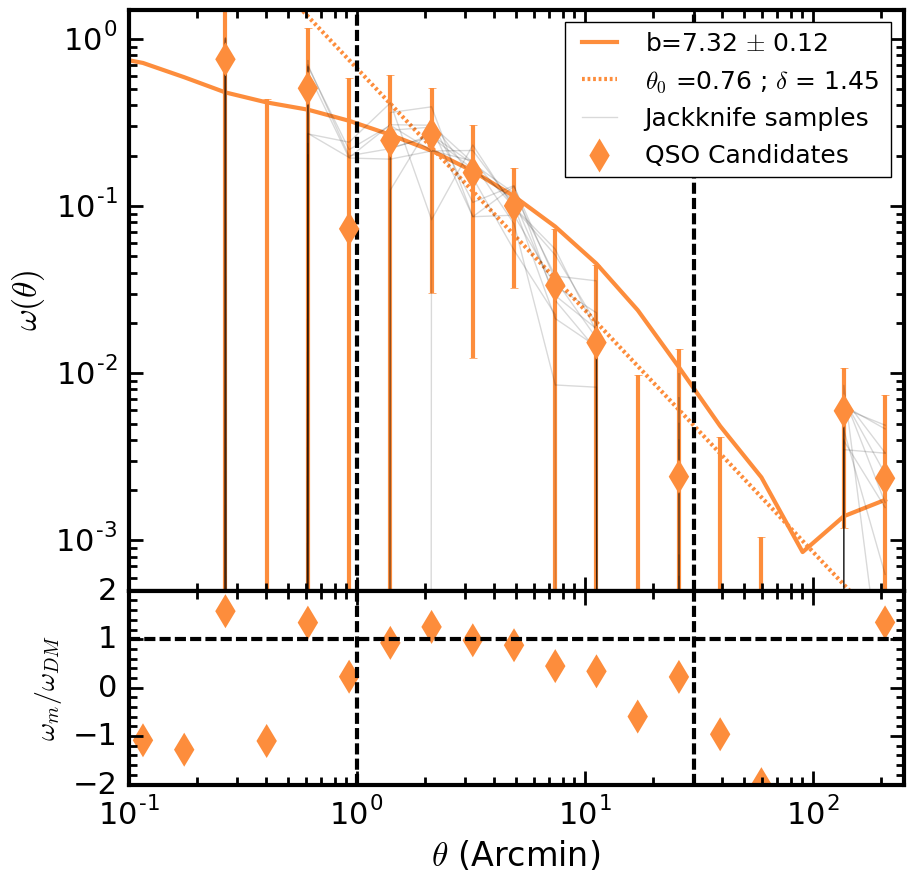

In [212]:
from matplotlib import gridspec
params = {'legend.fontsize': 16, 'xtick.labelsize': 22, 'ytick.labelsize': 22, 'xtick.major.width':2, 'xtick.minor.width':2, 'ytick.major.width':2, 'ytick.minor.width':2, 'xtick.major.size':10, 'xtick.minor.size':6, 'ytick.major.size':10, 'ytick.minor.size':6}
plt.rcParams.update(params)
plt.rc("axes", linewidth=3.0)

ptsz = 300
lwth = 3

#Plot for paper
fig = plt.figure(3,figsize = (10,10))
gs = gridspec.GridSpec(2, 1, height_ratios=[0.75,0.25])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharex = ax0)

plt.axes(ax0)
plt.scatter(separation[0],wnames[0],s = ptsz,color='#fd8d3c', marker = 'd',edgecolor='None',label=r'QSO Candidates',zorder = 100)
plt.errorbar(separation[0],wnames[0],yerr=sigma[0]**0.5,elinewidth=lwth,fmt=',',color='#fd8d3c')
#Poisson Error
#plt.errorbar(separation[0],wnames[0],yerr=np.sqrt((1.0+np.asarray(wnames[0]))/np.asarray(DDnames[0])),elinewidth=2,fmt=',',color='g')

#No Stellar contamination in fit
#plt.plot(separation[0],La,linestyle = '--', dashes = (8,3,8,3),linewidth = 2,color = '#fd8d3c',label='DM model b=%0.2f'%allzbias[0])

#With Stellar contamination in fit
plt.plot(separation[0],Las,linewidth = lwth,color = '#fd8d3c',label = r'b=%0.2f $\pm$ %0.2f'%(allzb[0],allzcov[0][0]))

#Power law fit
plt.plot(separation[0],allpow,color='#fd8d3c',linewidth = lwth, linestyle = ':',dashes = (2,2,2,2),label = r'$\theta_0$ =%0.2f ; $\delta$ = %0.2f '%(apfit[0],apfit[1]))

for i in range(len(JK_xi[0])): 
    if i == len(JK_xi[0])-1:
        plt.plot(separation[0],JK_xi[0][i],color='k',alpha = 0.15, linewidth = 1,label='Jackknife samples')
    else:
        #plt.scatter(separation[0],JK_xi[0][i],s = 15,color='k',alpha = 0.5, marker = 's',edgecolor='None')
        plt.plot(separation[0],JK_xi[0][i],color='k',alpha = 0.15, linewidth = 1)

        ax0.set_ylim(5e-4,1.5)

ax0.axvline(1,linewidth = lwth, linestyle = '--', dashes = (8,3,8,3), color = 'k')
ax0.axvline(30,linewidth = lwth, linestyle = '--', dashes = (8,3,8,3), color = 'k')
ax0.set_yscale('log')
ax0.set_ylabel(r'$\omega (\theta)$',fontsize = 24)
ax0.legend(fontsize = 18, scatterpoints=1)

plt.axes(ax1)
plt.axhline(1,linewidth = lwth, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.axvline(1,linewidth = lwth, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.axvline(30,linewidth = lwth, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.scatter(separation[0],np.asarray(wnames[0])/Las,s = ptsz,color='#fd8d3c', marker = 'd',edgecolor='None' )
ax1.yaxis.set_ticks([-2,-1,0,1,2])
ax1.set_ylabel(r'$\omega_m / \omega_{DM}$', fontsize = 20)

plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.xlim(0.1,250)
plt.ylim(-2,2)
plt.xscale('log')
plt.xlabel(r'$\theta$ (Arcmin)',fontsize = 24)

#plt.savefig('./Paper_plots/SpIES_corrfunc_only.png',bbox_inches='tight')

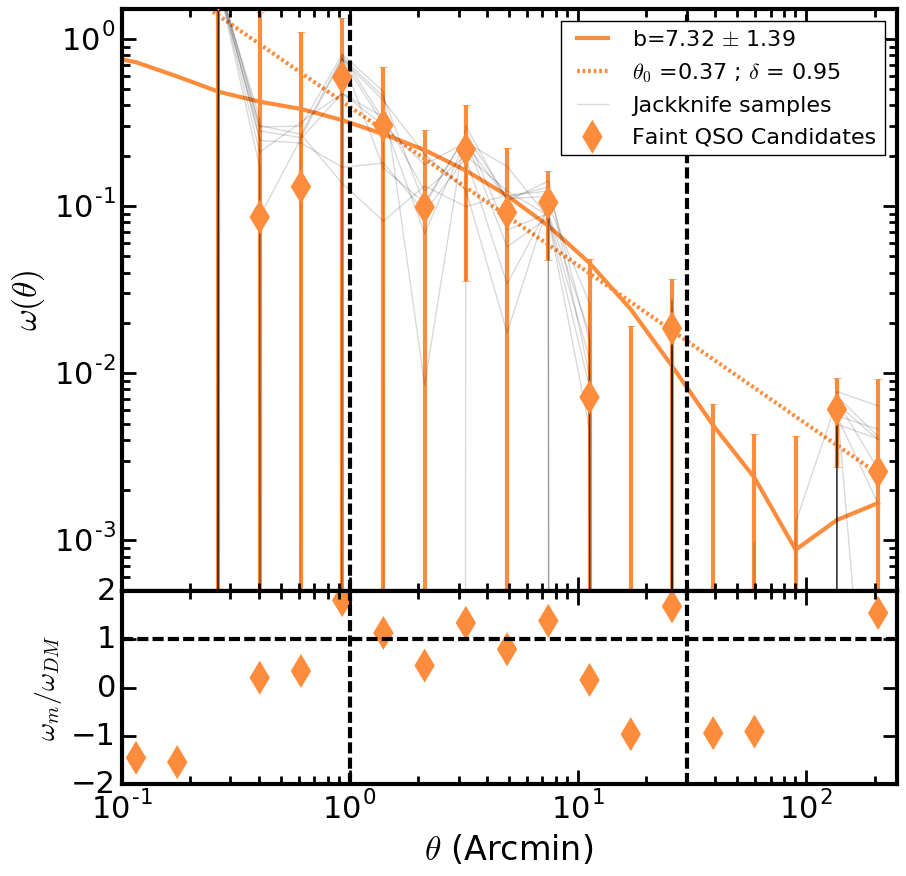

In [22]:
from matplotlib import gridspec
params = {'legend.fontsize': 16, 'xtick.labelsize': 22, 'ytick.labelsize': 22, 'xtick.major.width':2, 'xtick.minor.width':2, 'ytick.major.width':2, 'ytick.minor.width':2, 'xtick.major.size':10, 'xtick.minor.size':6, 'ytick.major.size':10, 'ytick.minor.size':6}
plt.rcParams.update(params)
plt.rc("axes", linewidth=3.0)

ptsz = 300
lwth = 3

#Plot for paper
fig = plt.figure(3,figsize = (10,10))
gs = gridspec.GridSpec(2, 1, height_ratios=[0.75,0.25])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharex = ax0)

plt.axes(ax0)
plt.scatter(separation[0],wnames[1],s = ptsz,color='#fd8d3c', marker = 'd',edgecolor='None',label=r'Faint QSO Candidates',zorder = 100)
plt.errorbar(separation[0],wnames[1],yerr=sigma[1]**0.5,elinewidth=lwth,fmt=',',color='#fd8d3c')
#Poisson Error
#plt.errorbar(separation[0],wnames[1],yerr=np.sqrt((1.0+np.asarray(wnames[1]))/(np.asarray(DDnames[1])*1.5)),elinewidth=2,fmt=',',color='g')

#No Stellar contamination in fit
#plt.plot(separation[0],La,linestyle = '--', dashes = (8,3,8,3),linewidth = 2,color = '#fd8d3c',label='DM model b=%0.2f'%allzbias[0])

#With Stellar contamination in fit
plt.plot(separation[0],Lls,linewidth = lwth,color = '#fd8d3c',label = r'b=%0.2f $\pm$ %0.2f'%(lowzb[0],lowzcov[0][0]))

#Power law fit
plt.plot(separation[0],lowpow,color='#fd8d3c',linewidth = lwth, linestyle = ':',dashes = (2,2,2,2),label = r'$\theta_0$ =%0.2f ; $\delta$ = %0.2f '%(lpfit[0],lpfit[1]))

for i in range(len(JK_xi[1])): 
    if i == len(JK_xi[1])-1:
        plt.plot(separation[0],JK_xi[1][i],color='k',alpha = 0.15, linewidth = 1,label='Jackknife samples')
    else:
        #plt.scatter(separation[0],JK_xi[0][i],s = 15,color='k',alpha = 0.5, marker = 's',edgecolor='None')
        plt.plot(separation[0],JK_xi[1][i],color='k',alpha = 0.15, linewidth = 1)

        ax0.set_ylim(5e-4,1.5)

ax0.axvline(1,linewidth = lwth, linestyle = '--', dashes = (8,3,8,3), color = 'k')
ax0.axvline(30,linewidth = lwth, linestyle = '--', dashes = (8,3,8,3), color = 'k')
ax0.set_yscale('log')
ax0.set_ylabel(r'$\omega (\theta)$',fontsize = 24)
ax0.legend(fontsize = 16, scatterpoints=1)

plt.axes(ax1)
plt.axhline(1,linewidth = lwth, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.axvline(1,linewidth = lwth, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.axvline(30,linewidth = lwth, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.scatter(separation[1],np.asarray(wnames[1])/Lls,s = ptsz,color='#fd8d3c', marker = 'd',edgecolor='None' )
ax1.yaxis.set_ticks([-2,-1,0,1,2])
ax1.set_ylabel(r'$\omega_m / \omega_{DM}$', fontsize = 20)

plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.xlim(0.1,250)
plt.ylim(-2,2)
plt.xscale('log')
plt.xlabel(r'$\theta$ (Arcmin)',fontsize = 24)

#plt.savefig('./Paper_plots/SpIES_corrfunc_faint.png',bbox_inches='tight')

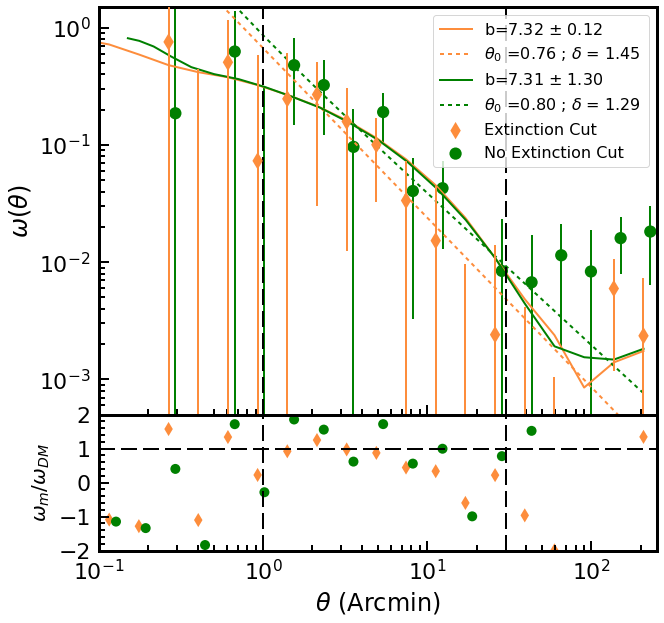

In [105]:
from matplotlib import gridspec
params = {'legend.fontsize': 16, 'xtick.labelsize': 22, 'ytick.labelsize': 22, 'xtick.major.width':2, 'xtick.minor.width':2, 'ytick.major.width':2, 'ytick.minor.width':2, 'xtick.major.size':10, 'xtick.minor.size':6, 'ytick.major.size':10, 'ytick.minor.size':6}
plt.rcParams.update(params)
plt.rc("axes", linewidth=3.0)

#Plot for paper
fig = plt.figure(3,figsize = (10,10))
gs = gridspec.GridSpec(2, 1, height_ratios=[0.75,0.25])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharex = ax0)

plt.axes(ax0)
plt.scatter(separation[0],wnames[0],s = 150,color='#fd8d3c', marker = 'd',edgecolor='None',label=r'Extinction Cut',zorder = 100)
plt.errorbar(separation[0],wnames[0],yerr=sigma[0]**0.5,elinewidth=2,fmt=',',color='#fd8d3c',zorder = 100)

#No Stellar contamination in fit
#plt.plot(separation[0],La,linestyle = '--', dashes = (8,3,8,3),linewidth = 2,color = '#fd8d3c',label='DM model b=%0.2f'%allzbias[0])

#With Stellar contamination in fit
plt.plot(separation[0],Las,linewidth = 2,color = '#fd8d3c',label = r'b=%0.2f $\pm$ %0.2f'%(allzb[0],allzcov[0][0]))

#Power law fit
plt.plot(separation[0],allpow,color='#fd8d3c',linewidth = 2, linestyle = ':',dashes = (2,2,2,2),label = r'$\theta_0$ =%0.2f ; $\delta$ = %0.2f '%(apfit[0],apfit[1]))
'''
for i in range(len(JK_xi[0])): 
    if i == len(JK_xi[0])-1:
        plt.plot(separation[0],JK_xi[0][i],color='k',alpha = 0.15, linewidth = 1,label='Jackknife samples')
    else:
        #plt.scatter(separation[0],JK_xi[0][i],s = 15,color='k',alpha = 0.5, marker = 's',edgecolor='None')
        plt.plot(separation[0],JK_xi[0][i],color='k',alpha = 0.15, linewidth = 1)

        ax0.set_ylim(5e-4,1.5)
'''
        
        
plt.scatter(np.asarray(separation[0])+0.1*np.asarray(separation[0]),wnames[2],s = 150,color='g', marker = 'o',edgecolor='None',label=r'No Extinction Cut')
plt.errorbar(np.asarray(separation[0])+0.1*np.asarray(separation[0]),wnames[2],yerr=sigma[2]**0.5,elinewidth=2,fmt=',',color='g')

#No Stellar contamination in fit
#plt.plot(separation[0],La,linestyle = '--', dashes = (8,3,8,3),linewidth = 2,color = '#fd8d3c',label='DM model b=%0.2f'%allzbias[0])

#With Stellar contamination in fit
plt.plot(np.asarray(separation[0])+0.1,Lhs,linewidth = 2,color = 'g',label = r'b=%0.2f $\pm$ %0.2f'%(highzb[0],highzcov[0][0]))

#Power law fit
plt.plot(np.asarray(separation[0])+0.1,highpow,color='g',linewidth = 2, linestyle = ':',dashes = (2,2,2,2),label = r'$\theta_0$ =%0.2f ; $\delta$ = %0.2f '%(hpfit[0],hpfit[1]))
'''
for i in range(len(JK_xi[0])): 
    if i == len(JK_xi[0])-1:
        plt.plot(separation[0],JK_xi[2][i],color='k',alpha = 0.15, linewidth = 1,label='Jackknife samples')
    else:
        #plt.scatter(separation[0],JK_xi[0][i],s = 15,color='k',alpha = 0.5, marker = 's',edgecolor='None')
        plt.plot(separation[0],JK_xi[2][i],color='k',alpha = 0.15, linewidth = 1)

        ax0.set_ylim(5e-4,1.5)
'''
ax0.set_ylim(5e-4,1.5)
ax0.axvline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
ax0.axvline(30,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
ax0.set_yscale('log')
ax0.set_ylabel(r'$\omega (\theta)$',fontsize = 24)
ax0.legend(fontsize = 16, scatterpoints=1)

plt.axes(ax1)
plt.axhline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.axvline(1,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.axvline(30,linewidth = 2, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.scatter(separation[0],np.asarray(wnames[0])/Las,s = 100,color='#fd8d3c', marker = 'd',edgecolor='None' )
plt.scatter(separation[0]+0.1*np.asarray(separation[0]),np.asarray(wnames[2])/Lhs,s = 100,color='g', marker = 'o',edgecolor='None' )
ax1.yaxis.set_ticks([-2,-1,0,1,2])
ax1.set_ylabel(r'$\omega_m / \omega_{DM}$', fontsize = 20)

plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.xlim(0.1,250)
plt.ylim(-2,2)
plt.xscale('log')
plt.xlabel(r'$\theta$ (Arcmin)',fontsize = 24)

#plt.savefig('./Paper_plots/SpIES_corrfunc_extinctioncut.pdf',bbox_inches='tight')

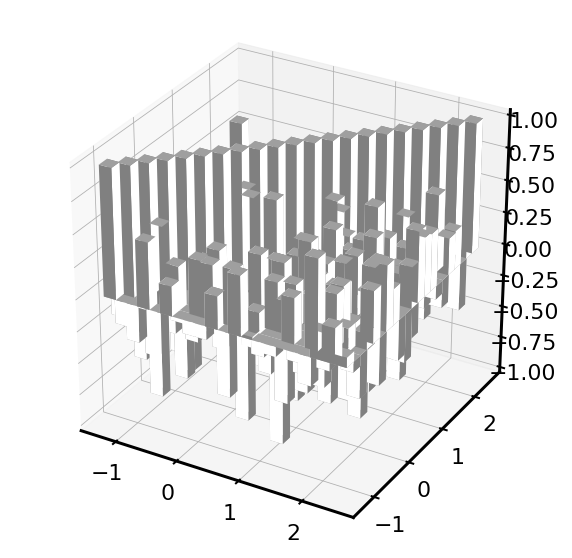

In [106]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(6,figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

# Construct arrays for the anchor positions of the 16 bars.
# Note: np.meshgrid gives arrays in (ny, nx) so we use 'F' to flatten xpos,
# ypos in column-major order. For numpy >= 1.7, we could instead call meshgrid
# with indexing='ij'.
X,Y = np.meshgrid(np.log10(th),np.log10(th))
xpos = X.flatten('F')
ypos = Y.flatten('F')
zpos = np.zeros_like(xpos)

# Construct arrays with the dimensions for the 16 bars.
dx = 0.2*np.ones_like(zpos)
dy = dx.copy()
dz = regmat[0].flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='w', zsort='average')
ax.set_zlim(-1,1)

plt.show()

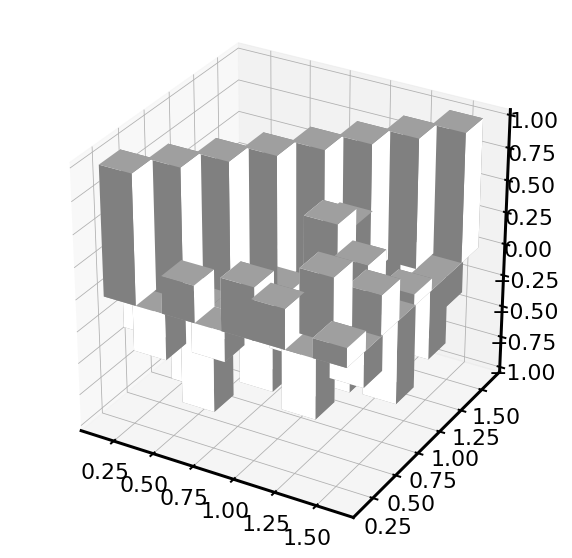

In [107]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

bdx = (np.asarray(separation[0])>1) & (np.asarray(separation[0])<30) 

fig = plt.figure(6,figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

# Construct arrays for the anchor positions of the 16 bars.
# Note: np.meshgrid gives arrays in (ny, nx) so we use 'F' to flatten xpos,
# ypos in column-major order. For numpy >= 1.7, we could instead call meshgrid
# with indexing='ij'.
X,Y = np.meshgrid(np.log10(np.asarray(separation[0])[bdx]),np.log10(np.asarray(separation[0])[bdx]))
xpos = X.flatten('F')
ypos = Y.flatten('F')
zpos = np.zeros_like(xpos)

# Construct arrays with the dimensions for the 16 bars.
dx = 0.2*np.ones_like(zpos)
dy = dx.copy()
dz = regmat[0][:,bdx][bdx,:].flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='w', zsort='average')
ax.set_zlim(-1,1)

plt.show()

In [196]:
#Biases from different surveys
### He 2017
bhe = 5.93
behe= 1.43
zhe = 3.8

### ROSS 2009
b = [2.06,1.41,1.38,1.45,1.83,2.37,1.92,2.42,2.79,3.62,2.99]
be = [0.03,0.18,0.06,0.38,0.33,0.25,0.5,0.4,0.47,0.49,1.42]
z = [1.27,0.24,0.49,0.80,1.03,1.23,1.41,1.58,1.74,1.92,2.10]

##SHEN 2007 Biases
#sb = [9.8,11.4,13.7]
#sz = [3,3.5,4]
sb = [7.9,14.0]
sbe = [0.8,2.0]
sz = [3.2,4]

### EFTEKHARZADEH
eb = [3.69,3.55,3.57]
ebe = [0.11,0.15,0.09]
ez = [2.297,2.497,2.971]

#### HOPKINS 2007 MODELS

maxdatH07 = open('../Plot_correlation/Hopkins07_clstr_maximal.dat','rw')
defdatH07 = open('../Plot_correlation/Hopkins07_clstr_default.dat','rw')
extdatH07 = open('../Plot_correlation/Hopkins07_clstr_extreme_feedback.dat','rw')

maxH07 = maxdatH07.readlines()
defH07 = defdatH07.readlines()
extH07 = extdatH07.readlines()


zH07 = []
bmH07 = []
bdH07 = []
beH07 = []

b20mH07 = []
b20eH07 = []
b20dH07 = []

for i in range(len(maxH07)):
    valm=maxH07[i].split()
    vald=defH07[i].split()
    vale=extH07[i].split()
    zH07.append(np.float(valm[0]))
    bmH07.append(np.float(valm[1]))
    bdH07.append(np.float(vald[1]))
    beH07.append(np.float(vale[1]))
    b20mH07.append(np.float(valm[3]))
    b20eH07.append(np.float(vale[3]))
    b20dH07.append(np.float(vald[3]))
    


7.32089892167 0.120896272098


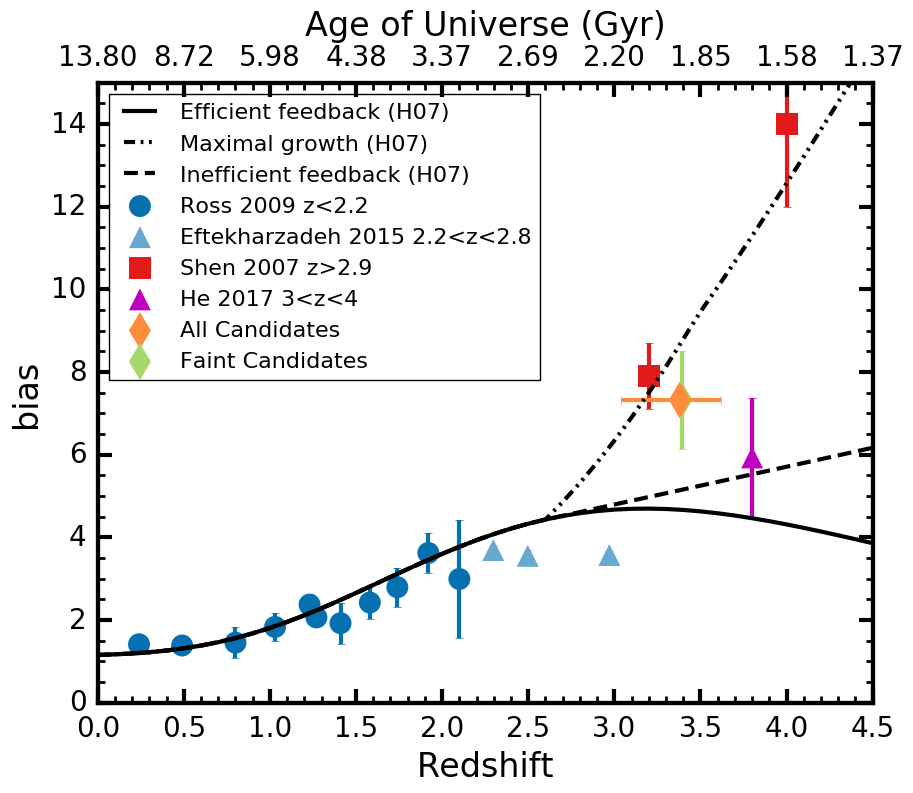

In [213]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

params = {'legend.fontsize': 16, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'xtick.major.width':3, 'xtick.minor.width':2, 'ytick.major.width':3, 'ytick.minor.width':2, 'xtick.major.size':10, 'xtick.minor.size':5, 'ytick.major.size':10, 'ytick.minor.size':5}
plt.rcParams.update(params)
plt.rc("axes", linewidth=3.0)
#plt.style.use('dark_background') 

fig = plt.figure(5,figsize=(10,8))
ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twiny()

plt.axes(ax1)

plt.scatter(z,b,s=250,c='#0571b0', marker = 'o', edgecolor = 'none', label='Ross 2009 z<2.2')
plt.errorbar(z,b,yerr=be,color='#0571b0', fmt=',',linewidth=3)

plt.scatter(ez,eb,s=250,c='#67a9cf', marker = '^',edgecolor = 'none', label='Eftekharzadeh 2015 2.2<z<2.8')
plt.errorbar(ez,eb,yerr=ebe,color='#67a9cf', fmt=',',linewidth=3)

plt.scatter(sz,sb,s=250,c='#e31a1c', marker = 's',edgecolor = 'none', label='Shen 2007 z>2.9')
plt.errorbar(sz,sb,yerr=sbe,color='#e31a1c', fmt=',',linewidth=3)

plt.scatter(zhe,bhe,s=250,c='m', marker = '^',edgecolor = 'none', label='He 2017 3<z<4')
plt.errorbar(zhe,bhe,yerr=behe,color='m', fmt=',',linewidth=3)

'''
#No stellar contam
plt.scatter(3.479,allzbias, marker = 'd',c='#ca0020', s=100, edgecolor = 'none', label = 'Candidates')
plt.errorbar(3.479,allzbias,yerr=0.22878057**0.5,color='#ca0020', fmt=',',linewidth=3)

plt.scatter(3.143,lowzbias, marker = 'd',c='#ca0020', s=100, edgecolor = 'none')
plt.errorbar(3.143,lowzbias,yerr=0.60656223**0.5,color='#ca0020', fmt=',',linewidth=3)

plt.scatter(3.803,highzbias, marker = 'd',c='#ca0020', s=100, edgecolor = 'none')
plt.errorbar(3.803,highzbias,yerr=0.50286617**0.5,color='#ca0020', fmt=',',linewidth=3)
'''
print allzb[0],allzcov[0][0]
axerror =np.array([[0.34 ,0.24]]).T
ftxerror =np.array([[0.34 ,0.25]]).T

#Stellar contam
plt.scatter(3.38,allzb[0], marker = 'd',c='#fd8d3c', s=350, edgecolor = 'none', label = 'All Candidates')
plt.errorbar(3.38,allzb[0],xerr= axerror, yerr=allzcov[0][0]**0.5,color='#fd8d3c', fmt=',',linewidth=3)

plt.scatter(3.39,lowzb[0], marker = 'd',c='#a6d96a', s=350, edgecolor = 'none',zorder = 0, label = 'Faint Candidates')
plt.errorbar(3.39,lowzb[0],xerr=0 ,yerr=lowzcov[0][0]**0.5,color='#a6d96a', fmt=',',linewidth=3,zorder = 0)

#plt.scatter(3.23,highzb[0], marker = 'd',c='#1a9641', s=100, edgecolor = 'none', label = 'Candidates rz match bin')
#plt.errorbar(3.23,highzb[0],xerr=0.0 , yerr=highzcov[0][0]**0.5,color='#1a9641', fmt=',',linewidth=3)

#plt.plot(zH07,b20mH07, linewidth = 2, linestyle='-', color='c',label = "i < 20.2 degeneracy")
plt.plot(zH07,beH07, linewidth = 3, linestyle='-', color='k',label = "Efficient feedback (H07)")
plt.plot(zH07,bmH07, linewidth = 3, linestyle='-.', color='k',dashes = (8,4,2,4,2,4), label = "Maximal growth (H07)")
plt.plot(zH07,bdH07, linewidth = 3, linestyle='--', dashes = (10,5,10,5), color='k',label = "Inefficient feedback (H07)")

#All feedback models
#plt.plot(zH07,b20mH07, linewidth = 2, linestyle=':', c='r',dashes = (3,2,3,2), label = r"All feedback models at $i$<20.2 (H07)")

#plt.plot(zH07,b20eH07, linewidth = 2, linestyle=':', c='r',dashes = (3,2,3,2), label = r"$i$=20.2 (H07)")
#plt.plot(zH07,b20dH07, linewidth = 2, linestyle=':', c='b',dashes = (3,2,3,2), label = r"Feedback models with $i$=20.2 (H07)")


def tick_function(X):
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.274)
    ages = cosmo.age(X).value
    lab = []
    for i in ages:
        lab.append(i)
    return ["%.2f" % z for z in lab]



ax1.set_xlim(0,4.5)

ax1Ticks = ax1.get_xticks()  
ax2Ticks = ax1Ticks

ax2.set_xticks(ax1Ticks)
ax2.set_xbound(ax1.get_xbound())
ax2.set_xticklabels(tick_function(ax2Ticks))

#ax2.set_xticklabels(ax1Ticks)


ax1.set_xlabel('Redshift',fontsize = 24) 
ax2.set_xlabel('Age of Universe (Gyr)',fontsize = 24)

plt.ylabel('bias',fontsize = 24)
plt.ylim(0,15)
plt.legend(loc = 2, scatterpoints=1)
plt.minorticks_on()
#plt.savefig('./Paper_plots/Bais_v_Redshift_poster.png')
plt.show()

In [39]:
#Import SpIES / SHELA data
data = '../Data_Sets/HZLZ_combined_all_hzclassifiers_wphotoz_zspecflg.fits'
obs = pf.open(data)[1].data
Z = obs.zbest
imag = -2.5/np.log(10) * (np.arcsinh((obs.iflux/1e9)/(2*1.8e-10))+np.log(1.8e-10)) 

gdx = ((Z >= 2.9) & (obs.dec>=-1.2) & (obs.dec<=1.2)& ((obs.ra>=344.4)|(obs.ra<60)))#&(imag >= 20.2))

#gdx = Z>0
#Set up a KDE for dNdz
tmpz = Z[gdx][:, np.newaxis] #change the array from row shape (1) to column shape (1,)
print np.shape(tmpz)
sample_range = np.linspace(min(tmpz[:, 0]), max(tmpz[:, 0]), len(tmpz[:, 0]))[:, np.newaxis]

est = kde(bandwidth=0.1,kernel='epanechnikov') #Set up the Kernel

histkde = est.fit(tmpz).score_samples(sample_range) #fit the kernel to the data and find the density of the grid
#Interpolate (you get the same function back) to plug in any z in the range (as opposed to set z values)
dNdz = interpolate.interp1d(sample_range.flatten(),np.exp(histkde))
print sample_range.flatten()
print 'done'
ZE = np.linspace(min(Z),max(Z),100)
xo=integrate.quad(dNdz,min(sample_range),max(sample_range)) #quad(f(x),xlower,xupper, args)
print xo
print 'median', np.median(Z[gdx])
print 'mean',np.mean(Z[gdx])
print 'max',np.max(Z[gdx])
print 'min',np.min(Z[gdx])

(1378, 1)
[ 2.9005184   2.90212296  2.90372752 ...,  5.10679101  5.10839557
  5.11000013]
done
(0.9683159136306184, 0.00021142137223073565)
median 3.23161621426
mean 3.38719277046
max 5.11000013351
min 2.9005184008


In [111]:
##REDSHIFT SPLITS

In [112]:
#open the angular results from the SHEN 2007 run
shen = './Shen_Angcor.txt'
shenjk = './Shen_Angcor_JK.txt'

datfiles2 = [shen]
JKfiles2 = [shenjk]


#Loop over the data files list to open and plot the correlation function
separation2 = []
wnames2 = []
RRnames2 = []
DDnames2 = []
for infile in datfiles2:
    fileopen = open(infile,'rw')
    header = fileopen.readline()
    data = fileopen.readlines() 

    th = []
    w = []
    RR = []
    DD = []
    for i in range(len(data)):
        t = float(data[i].split()[0]) #Theta
        x = float(data[i].split()[4]) #w(theta) 
        rr = float(data[i].split()[3]) #RR 
        dd = float(data[i].split()[1]) #DD
        w.append(x)
        RR.append(rr)
        DD.append(dd)
        th.append(t)
    #Put the w and RR values into an array to call for Jackknife calculation
    wnames2.append(w)
    RRnames2.append(RR)
    DDnames2.append(DD)
    separation2.append(th)

#Compute Jackknife errors from the counts information
sigma2 = []
covmat2 = []
for h in range(len(JKfiles2)):
    covariance = make_covariance(JKfiles[h], wnames[h], RRnames[h])
    sigma2.append(np.diag(covariance))
    covmat2.append(covariance)

#Compute the regression matrix
regmat2 = []
for h in range(len(wnames2)):
    regmat2.append(Regressmat(covmat2[h],th))

print np.shape(regmat2)


#Get jackknife w's
JK_xi2 = []
for h in range(len(JKfiles2)):
    jk = make_JKxi(JKfiles2[h], wnames2[h], RRnames2[h])
    JK_xi2.append(jk[0])

print np.shape(JK_xi2)
print len(separation2[0])


sth = separation2[0]
sw = wnames2[0]
sjk= sigma2[0]

print len(sth),len(sw),len(sjk)
print DDnames2[0]

#Theta DD DR RR XI factor=103.708998549 jknum= 10

(1, 21, 21)
(1, 10, 21)
21
21 21 21
[0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 4.0, 30.0, 46.0, 88.0, 200.0, 498.0, 1042.0, 2234.0, 5154.0, 11404.0, 25650.0, 53078.0, 113896.0]


In [113]:
#BOSS wtheta which I computed using a subset of Eft 2015 
Bth = [0.050323978983, 0.0763011640511, 0.115687744753, 0.175405637024, 0.265949842531, 0.403232871773, 0.611381256445, 0.926975618552, 1.40547945874, 2.13098647839, 3.23099945918, 4.89883798472, 7.42761300449, 11.2617390321, 17.0750368861, 25.8891529834, 39.2531065478, 59.5155188986, 90.2373672122, 136.817801341, 207.443006619]
Bwt = [-0.399949636665, -0.139493890308, -0.446243530879, 0.76311340272, -0.525602284033, -0.573893771779, -0.470477229437, -0.295626322384, 0.207851198524, 0.18424850005, 0.10315515435, 0.0983282856195, 0.0654036946897, 0.0349133960631, 0.0209796601689, 0.0199293887951, 0.014989772678, 0.0125284121898, 0.008932733109, 0.00654631771702, 0.00457786274708]

#The He 2017 points for small scales
heth = [2.05,3.25,5.15,8.15,12.92,20.48,32.46,51.45,81.55,129.24,204.84,324.65,514.53,815.48]
heth = np.asarray(heth)/60.

#Luminous sample
hew = [0,-1,0,-1,-0.33,1.96,-0.85,0.53,0.21,0.15,0.07,-0.07,0.05,-0.005]
hewe= [0,9.76,8.53,1.69,0.86,2.11,0.15,0.32,0.27,0.14,0.08,0.04,0.07,0.03]
#Less Luminous sample
hewll = [0,3.25,2.86,1.58,1.96,-0.11,0.36,-0.002,0.13,0.14,0.06,0.06,0.04,0.02]
hewell = [0,8.74,2.51,1.91,1.79,0.47,0.26,0.18,0.13,0.09,0.04,0.04,0.02,0.02]

/home/john/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in divide


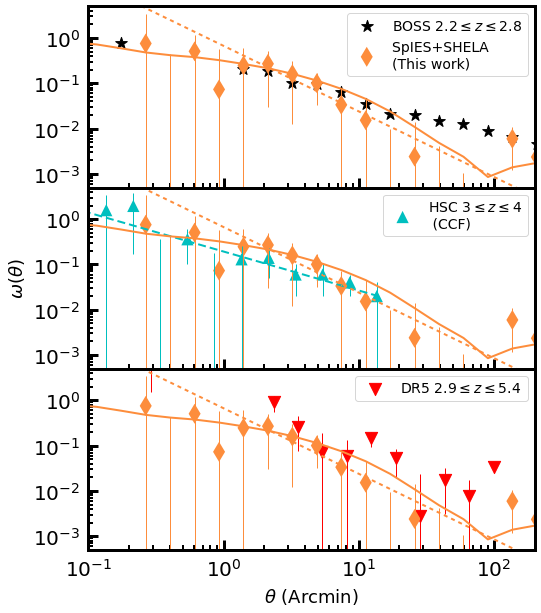

In [114]:
from matplotlib import gridspec
#Plotting Parameters (Replace with Group code call!)
params = {'legend.fontsize': 16, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'xtick.major.width':3, 'xtick.minor.width':2, 'ytick.major.width':3, 'ytick.minor.width':2, 'xtick.major.size':10, 'xtick.minor.size':5, 'ytick.major.size':10, 'ytick.minor.size':5}
plt.rcParams.update(params)
plt.rc("axes", linewidth=3.0)

#Plot for paper
fig = plt.figure(4,figsize = (8,10))
gs = gridspec.GridSpec(3, 1, height_ratios = [1,1,1], width_ratios=[1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharex = ax0)
ax2 = plt.subplot(gs[2],sharex = ax0)

#BOSS
ax0.scatter(Bth,Bwt,s=150,marker = '*', color = 'k',label = r'BOSS $2.2\leq z\leq 2.8$')
#lowz comparison to BOSS
ax0.scatter(separation[0],wnames[0],s = 200,color='#fd8d3c', marker = 'd', edgecolor='None',label='SpIES+SHELA \n'+r'(This work)')
ax0.errorbar(separation[0],wnames[0],yerr=sigma[0]**0.5,elinewidth=1,fmt=',',color='#fd8d3c')
ax0.plot(separation[0],Las,linewidth = 2,color = '#fd8d3c')#,label='Low-z bias=%0.2f'%lowzb[0])
#ax0.plot(separation[1],Ll,linewidth = 2,color = '#a6d96a',label='Low-z bias=%s'%lowzbias)
ax0.plot(separation[0],allpow,color='#fd8d3c',linewidth = 2, linestyle = ':',dashes = (2,2,2,2))#,label = r'$\theta_0$ =%0.2f ; $\delta$ = %0.2f '%(lpfit[0],lpfit[1]))


ax0.set_ylim(5*10**-4,5)
ax0.set_yscale('log')
#ax0.set_ylabel(r'$\omega (\theta)$',fontsize = 18)
ax0.legend(fontsize = 14, scatterpoints=1)


#He less luminous
ax1.scatter(heth,hewll,s = 150,color='c', marker = '^',edgecolor='None',label='HSC $3\leq z\leq 4$'+'\n (CCF)')
ax1.errorbar(heth,hewll,yerr=hewell,elinewidth=1,fmt=',',color='c')
ax1.plot(heth,6.53/60.**0.86*heth**-0.86,color='c',linewidth = 2, linestyle = '--',dashes = (4,2,4,2))

#highz candidates comparison to HE
ax1.scatter(separation[0],wnames[0],s = 200,color='#fd8d3c', marker = 'd', edgecolor='None')
ax1.errorbar(separation[0],wnames[0],yerr=sigma[0]**0.5,elinewidth=1,fmt=',',color='#fd8d3c')
ax1.plot(separation[0],Las,linewidth = 2,color = '#fd8d3c')#,label='Low-z bias=%0.2f'%lowzb[0])
#ax0.plot(separation[1],Ll,linewidth = 2,color = '#a6d96a',label='Low-z bias=%s'%lowzbias)
ax1.plot(separation[0],allpow,color='#fd8d3c',linewidth = 2, linestyle = ':',dashes = (2,2,2,2))#,label = r'$\theta_0$ =%0.2f ; $\delta$ = %0.2f '%(lpfit[0],lpfit[1]))

ax1.set_ylim(5*10**-4,5)
ax1.set_yscale('log')
ax1.set_ylabel(r'$\omega (\theta)$',fontsize = 18)
ax1.legend(fontsize = 14, scatterpoints=1)


#Shen data
ax2.scatter(np.asarray(sth)+0.1*np.asarray(sth),sw,s=150,marker = 'v', color = 'r',label = r'DR5 $2.9\leq z\leq 5.4$ ')
ax2.errorbar(np.asarray(sth)+0.1*np.asarray(sth),sw,yerr=(1.0+np.asarray(sw))/np.sqrt(np.asarray(DDnames2[0])),elinewidth=1,fmt=',',color='r')
#full candidate list
ax2.scatter(separation[0],wnames[0],s = 200,color='#fd8d3c', marker = 'd', edgecolor='None')
ax2.errorbar(separation[0],wnames[0],yerr=sigma[0]**0.5,elinewidth=1,fmt=',',color='#fd8d3c')
ax2.plot(separation[0],Las,linewidth = 2,color = '#fd8d3c')#,label='Low-z bias=%0.2f'%lowzb[0])
#ax0.plot(separation[1],Ll,linewidth = 2,color = '#a6d96a',label='Low-z bias=%s'%lowzbias)
ax2.plot(separation[0],allpow,color='#fd8d3c',linewidth = 2, linestyle = ':',dashes = (2,2,2,2))#,label = r'$\theta_0$ =%0.2f ; $\delta$ = %0.2f '%(lpfit[0],lpfit[1]))

ax2.set_ylim(5*10**-4,5)
ax2.set_yscale('log')
#ax2.set_ylabel(r'$\omega (\theta)$',fontsize = 18)
ax2.legend(fontsize = 14, scatterpoints=1)



plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlim(0.1,200)
plt.xscale('log')
plt.xlabel(r'$\theta$ (Arcmin)',fontsize = 18)
#plt.ylabel(r'$\omega (\theta)$',fontsize = 18)


#plt.savefig('./Paper_plots/comparison_corrfunc_new.pdf',bbox_inches='tight')
#fig.tight_layout()

plt.show()


In [242]:
print sigma[0][bdx]**0.5

[ 0.36231157  0.23849587  0.14610923  0.06797061  0.0398463   0.02948382
  0.01156145]


In [258]:
bdx = (np.asarray(separation[0])>1) & (np.asarray(separation[0])<30)& (np.asarray(wnames[0])>0) 
allzb, allzcov = curve_fit(stellar_cont, np.asarray(Limbera(separation[0])[bdx]), np.asarray(wnames[0])[bdx], sigma = sigma[0][bdx]**0.5,absolute_sigma=False, bounds=([0,0.],[np.inf,np.inf]))
lowzb, lowzcov = curve_fit(stellar_cont, np.asarray(Limberl(separation[1])[bdx]), np.asarray(wnames[1])[bdx], sigma = sigma[1][bdx]**0.5,absolute_sigma=True, bounds=([0,0.],[np.inf,np.inf]))

Las2 = stellar_cont(Limbera(separation[0]),allzb[0],allzb[1])
print allzb[0], '+/-', allzcov[0][0]**0.5
print allzb[1], '+/-', allzcov[1][1]**0.5
print ' ' 
print lowzb[0], '+/-', lowzcov[0][0]
print lowzb[1], '+/-', lowzcov[1][1]


allpow1, apowcov = curve_fit(powlaw, np.asarray(separation[0])[bdx], np.asarray(wnames[0])[bdx], sigma = sigma[0][bdx]**0.5,absolute_sigma=True)
lowpow1, lpowcov = curve_fit(powlaw, np.asarray(separation[1])[bdx], np.asarray(wnames[1])[bdx], sigma = sigma[1][bdx]**0.5,absolute_sigma=True)




5.82112292325 +/- 0.845402000136
5.42714043358e-12 +/- 0.00637286577617
 
6.56159927794 +/- 4.02298908696
0.00619567578948 +/- 0.000380436078286


In [253]:
###TESTING CURVE FIT
from lmfit import Model

bdx = (np.asarray(separation[0])>1) & (np.asarray(separation[0])<30)& (np.asarray(wnames[0])>0) 


model = Model(stellar_cont,intependent_vars=['Limb'])
result = model.fit(np.asarray(wnames[0])[bdx], Limb = np.asarray(Limbera(separation[0])[bdx]), b=3,e=0.001, weights=np.diag(covmat[0][:,bdx][bdx,:])**0.5)
print result.values
print result.params

{'b': 6.1826740931958373, 'e': 0.068509404673337854}
Parameters([('b', <Parameter 'b', value=6.1826740931958373 +/- 1.31, bounds=[-inf:inf]>), ('e', <Parameter 'e', value=0.068509404673337854 +/- 0.0726, bounds=[-inf:inf]>)])


In [254]:
def chi2min(y, y_err, model):
    # x, y, y_err are 1-D arrays of the same length,
    # model is a function that can be evaluated at the
    # values of x to get corresponding values to y

    from scipy.stats import chisquare
    from scipy.optimize import minimize
    
    # chi2 is a function that returns the chi-squared value
    # given only model parameters
    chi2 = lambda paramarray: chisquare(
                        model(paramarray[0],paramarray[1])/y_err**2,
                        y/y_err**2,
                            )[0]

    # [1., 1.] are initial guesses for parameters
    param1min, param2min = minimize(chi2, [1., 1.]).x

    return param1min, param2min

def mod(b,e):
    return stellar_cont(np.asarray(Limbera(separation[0])[bdx]),b,e)

dat = np.asarray(wnames[0])[bdx]
dater=np.diag(covmat[0][:,bdx][bdx,:])**0.5 


chi2min(dat,dater,mod)

(5.2988500903874352, -0.0042237605032155465)

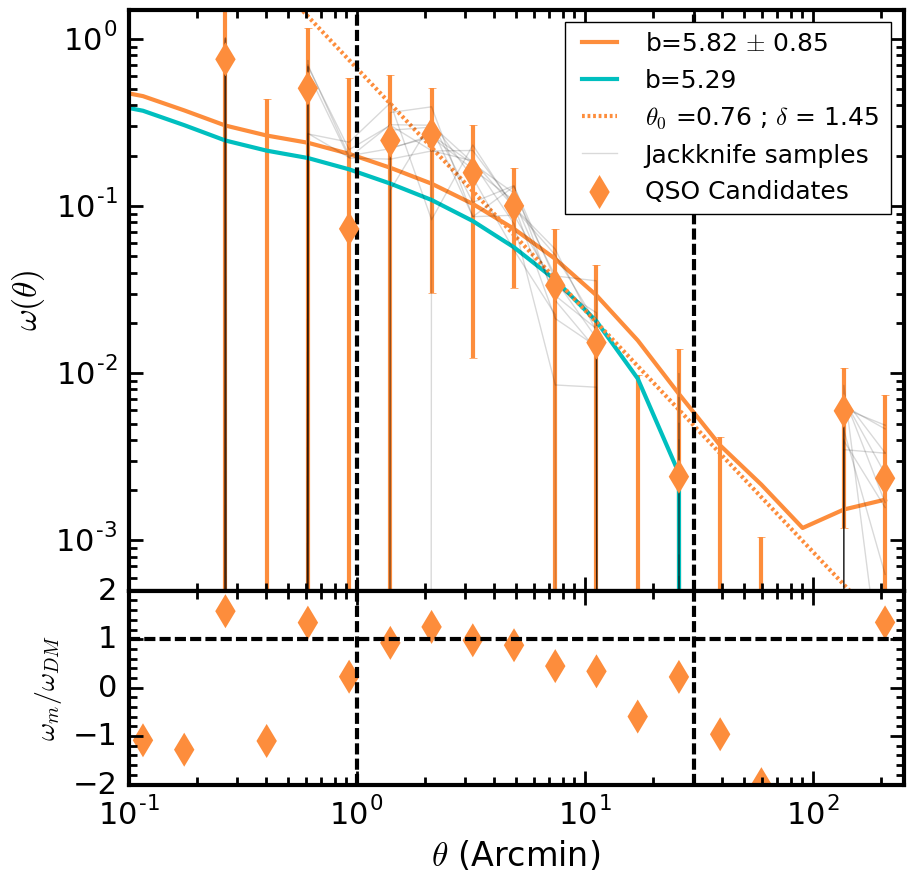

In [255]:
from matplotlib import gridspec
params = {'legend.fontsize': 16, 'xtick.labelsize': 22, 'ytick.labelsize': 22, 'xtick.major.width':2, 'xtick.minor.width':2, 'ytick.major.width':2, 'ytick.minor.width':2, 'xtick.major.size':10, 'xtick.minor.size':6, 'ytick.major.size':10, 'ytick.minor.size':6}
plt.rcParams.update(params)
plt.rc("axes", linewidth=3.0)

ptsz = 300
lwth = 3

#Plot for paper
fig = plt.figure(3,figsize = (10,10))
gs = gridspec.GridSpec(2, 1, height_ratios=[0.75,0.25])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharex = ax0)

plt.axes(ax0)
plt.scatter(separation[0],wnames[0],s = ptsz,color='#fd8d3c', marker = 'd',edgecolor='None',label=r'QSO Candidates',zorder = 100)
plt.errorbar(separation[0],wnames[0],yerr=sigma[0]**0.5,elinewidth=lwth,fmt=',',color='#fd8d3c')
#Poisson Error
#plt.errorbar(separation[0],wnames[0],yerr=np.sqrt((1.0+np.asarray(wnames[0]))/np.asarray(DDnames[0])),elinewidth=2,fmt=',',color='g')

#No Stellar contamination in fit
#plt.plot(separation[0],La,linestyle = '--', dashes = (8,3,8,3),linewidth = 2,color = '#fd8d3c',label='DM model b=%0.2f'%allzbias[0])

#With Stellar contamination in fit
plt.plot(separation[0],Las2,linewidth = lwth,color = '#fd8d3c',label = r'b=%0.2f $\pm$ %0.2f'%(allzb[0],allzcov[0][0]**0.5))
plt.plot(separation[0],stellar_cont(Limbera(separation[0]),5.29,-0.004),linewidth = lwth,color = 'c',label = 'b=5.29')

#Power law fit
plt.plot(separation[0],allpow,color='#fd8d3c',linewidth = lwth, linestyle = ':',dashes = (2,2,2,2),label = r'$\theta_0$ =%0.2f ; $\delta$ = %0.2f '%(apfit[0],apfit[1]))

for i in range(len(JK_xi[0])): 
    if i == len(JK_xi[0])-1:
        plt.plot(separation[0],JK_xi[0][i],color='k',alpha = 0.15, linewidth = 1,label='Jackknife samples')
    else:
        #plt.scatter(separation[0],JK_xi[0][i],s = 15,color='k',alpha = 0.5, marker = 's',edgecolor='None')
        plt.plot(separation[0],JK_xi[0][i],color='k',alpha = 0.15, linewidth = 1)

        ax0.set_ylim(5e-4,1.5)

ax0.axvline(1,linewidth = lwth, linestyle = '--', dashes = (8,3,8,3), color = 'k')
ax0.axvline(30,linewidth = lwth, linestyle = '--', dashes = (8,3,8,3), color = 'k')
ax0.set_yscale('log')
ax0.set_ylabel(r'$\omega (\theta)$',fontsize = 24)
ax0.legend(fontsize = 18, scatterpoints=1)

plt.axes(ax1)
plt.axhline(1,linewidth = lwth, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.axvline(1,linewidth = lwth, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.axvline(30,linewidth = lwth, linestyle = '--', dashes = (8,3,8,3), color = 'k')
plt.scatter(separation[0],np.asarray(wnames[0])/Las,s = ptsz,color='#fd8d3c', marker = 'd',edgecolor='None' )
ax1.yaxis.set_ticks([-2,-1,0,1,2])
ax1.set_ylabel(r'$\omega_m / \omega_{DM}$', fontsize = 20)

plt.subplots_adjust(hspace=.0)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.xlim(0.1,250)
plt.ylim(-2,2)
plt.xscale('log')
plt.xlabel(r'$\theta$ (Arcmin)',fontsize = 24)


5.82112292325 0.714704541834


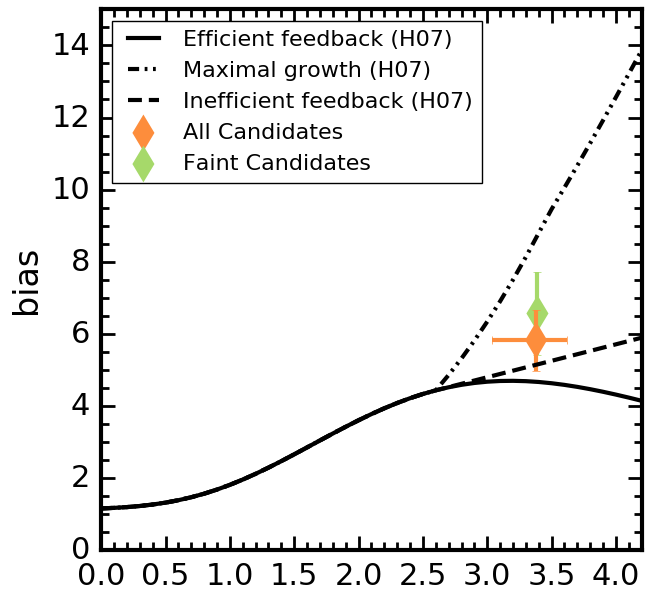

In [256]:
print allzb[0],allzcov[0][0]
axerror =np.array([[0.34 ,0.24]]).T
ftxerror =np.array([[0.34 ,0.25]]).T

#Stellar contam
plt.scatter(3.38,allzb[0], marker = 'd',c='#fd8d3c', s=350, edgecolor = 'none', label = 'All Candidates')
plt.errorbar(3.38,allzb[0],xerr= axerror, yerr=allzcov[0][0]**0.5,color='#fd8d3c', fmt=',',linewidth=3)

plt.scatter(3.39,lowzb[0], marker = 'd',c='#a6d96a', s=350, edgecolor = 'none',zorder = 0, label = 'Faint Candidates')
plt.errorbar(3.39,lowzb[0],xerr=0 ,yerr=lowzcov[0][0]**0.5,color='#a6d96a', fmt=',',linewidth=3,zorder = 0)

#plt.scatter(3.23,highzb[0], marker = 'd',c='#1a9641', s=100, edgecolor = 'none', label = 'Candidates rz match bin')
#plt.errorbar(3.23,highzb[0],xerr=0.0 , yerr=highzcov[0][0]**0.5,color='#1a9641', fmt=',',linewidth=3)

#plt.plot(zH07,b20mH07, linewidth = 2, linestyle='-', color='c',label = "i < 20.2 degeneracy")
plt.plot(zH07,beH07, linewidth = 3, linestyle='-', color='k',label = "Efficient feedback (H07)")
plt.plot(zH07,bmH07, linewidth = 3, linestyle='-.', color='k',dashes = (8,4,2,4,2,4), label = "Maximal growth (H07)")
plt.plot(zH07,bdH07, linewidth = 3, linestyle='--', dashes = (10,5,10,5), color='k',label = "Inefficient feedback (H07)")

#All feedback models
#plt.plot(zH07,b20mH07, linewidth = 2, linestyle=':', c='r',dashes = (3,2,3,2), label = r"All feedback models at $i$<20.2 (H07)")

#plt.plot(zH07,b20eH07, linewidth = 2, linestyle=':', c='r',dashes = (3,2,3,2), label = r"$i$=20.2 (H07)")
#plt.plot(zH07,b20dH07, linewidth = 2, linestyle=':', c='b',dashes = (3,2,3,2), label = r"Feedback models with $i$=20.2 (H07)")



def tick_function(X):
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.274)
    ages = cosmo.age(X).value
    lab = []
    for i in ages:
        lab.append(i)
    return ["%.2f" % z for z in lab]



ax1.set_xlim(0,4.5)

ax1Ticks = ax1.get_xticks()  
ax2Ticks = ax1Ticks

ax2.set_xticks(ax1Ticks)
ax2.set_xbound(ax1.get_xbound())
ax2.set_xticklabels(tick_function(ax2Ticks))

#ax2.set_xticklabels(ax1Ticks)


ax1.set_xlabel('Redshift',fontsize = 24) 
ax2.set_xlabel('Age of Universe (Gyr)',fontsize = 24)

plt.ylabel('bias',fontsize = 24)
plt.ylim(0,15)
plt.xlim(0,4.2)
plt.legend(loc = 2, scatterpoints=1)
plt.minorticks_on()